# Data Analysis - BA Noah Ploch

In [2]:
### TODO
#### implement abbruchbedingung
#### PAUSE: Check for zick zack in Data: as R fluctuates heavily close to Tc, maybe we just measured R at  
#### fit diffusivity at different fit ranges to see if huge diffrence, make as well all three values in plot to see if linearity or so and that it was just a fit error
### IMPORTANT NOTE: first execute on of the Search file cells that use pyqt5. after obviuosly getting an error because no packages were imported, start executing from the top the important cells

### IMPORTANT. to work with Tc curves from 0T and cooldown, sweep fitting has been deactivated and ranges in fit_cdf_over_range have been changed in T_Sweep class!

### 1. import relevant libraries

In [2]:
from PyQt5.QtWidgets import QFileDialog  
import json as js
import numpy as np
import pandas as pd
from pathlib import Path, PureWindowsPath
from scipy import io
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.special import erf
from scipy.constants import elementary_charge, Boltzmann 
from math import pi
from math import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
import decimal

import os
import timeit
from bisect import bisect_left, bisect_right
import re
import itertools

In [3]:
import warnings
#warnings.filterwarnings("error")
warnings.filterwarnings("default")

## CODE

#### T_Sweep

In [4]:
# Definition of needed classes
class Data_sweep():
    
    def __init__(self, raw_data, *calibration_data):
        self._raw_data = raw_data # to take into account: raw data in columns, processed data in rows
        try:
            self.calibration_data = calibration_data[0]
        except:
            self.calibration_data = -1
        self._raw_fit = []
        self._sweep_raw = []
        self.sweep_smooth = []
        self.sweep_fit = []
        self.n_moving_average_separate_sweeps= floor(len(self._raw_data)/42) # 42 was figured out as an appropriate value (the answer for everything)
        self.x_array = np.arange(4,16,0.01)
        self.T_meas_error_pp = 0.0125 # in percent, estimated interpolation error
        self.T_meas_error_std = 0.02 # standard deviation of measurements at 4Kelvin
        self.R_meas_error_pp = 0.017 # from maximal resistance value as reference for the relative error
        
class T_sweep(Data_sweep):
    
    def __init__(self, raw_data):
        self.Tc = []
        self.R20K = 0
        self.FWHM = 0
        Data_sweep.__init__(self, raw_data)
        self.get_20K_resistance()
        self.moving_average_reach = ceil(len(self._raw_data)/1000) # this ratio might be rethought
        print("Len raw data: ", len(self._raw_data))
        print("Moving average to separate sweeps: ", self.n_moving_average_separate_sweeps)
        print("Moving average to smooth sweeps: ", self.moving_average_reach)
        #self.import_data(raw_data, self.moving_average_reach)
        self.fit_cdf_over_range_raw()
        #self.fit_all_sweeps(self._sweep_raw)
        
        #self.get_FWHM()
        
    
    def find_index_to_split_curves(self,smooth_T): # this function aims to split the raw data set into the sweeps done btw superconducting and normal conducting
        T_gradient = np.diff(smooth_T) # numeric change from one datapoint to next one in temperature
        # this command first evaluates whether the former differences are positive or negative and then differentiates again
        # to get the turning points. To do so, np.where evaluates true where condition is fulfilled, and in python a difference is only false if it holds 0
        # That means, only differences in different  direction hold True and are therefore used to split the raw data
        split_indices = np.where(np.diff(np.signbit(T_gradient)))[0] + 1
        if split_indices != []:
            #print(split_indices)
            diff_indices = np.diff(split_indices) # difference of the split indices used to determine if split is sensible
            diff_indices = np.insert(diff_indices, 0, split_indices[0]) # insertion of a 0 at beginning to calculate first index difference as well (see np.diff doc)
            #print(diff_indices)
            # gives back the split index if it holds more that 500 data points to the former split index, otherwise returns 0
            indices = np.where(diff_indices>500, split_indices, 0)
            return indices[indices>0] # returns the useful split indices according to logic just above
        else: return []
        
    def apply_moving_average(self, n_moving_average, sweep): # application of moving average with a rectangle slided over the data points with height 1/(data points over which one averages)
        return np.convolve(np.ones((n_moving_average,), dtype=int)/n_moving_average, sweep, 'valid') 
        # pandas alternative calculation to moving average: df.mean.rolling
    
    def __create_sweeps(self, data):
        smooth_T = self.apply_moving_average(self.n_moving_average_separate_sweeps, data[:,0]) # very smoothed T values
        smooth_R = self.apply_moving_average(self.n_moving_average_separate_sweeps, data[:,1]) # think it is not used at moment...
        T_extrema_indices = self.find_index_to_split_curves(smooth_T)
        if T_extrema_indices == []:
            self._sweep_raw.append(np.array([data[:, 0], data[:, 1]]))
        else:
            T_extrema_indices = np.append(T_extrema_indices, len(smooth_T)-1) # find_index_to_split_curves only gives back indices where to split, so final index has to be included as well to define last sweep
            print("cut indices: ", T_extrema_indices)
            old_i = 0
            for i in T_extrema_indices:
                # here happens the change from data organized in columns (x,y) to organized in row x and row y in np array
                print(i)
                self._sweep_raw.append(np.array([data[old_i:i, 0], data[old_i:i, 1]]))             
                old_i = i
            #print(self._sweep_raw)
        
    def import_data(self, data, moving_average_reach):
        self._raw_data = data
        self.__create_sweeps(self._raw_data)
        for i in self._sweep_raw:
            self.sweep_smooth.append(np.array([self.apply_moving_average(moving_average_reach, i[0,:]), self.apply_moving_average(moving_average_reach, i[1,:])]))

    
    def reload_data(self, moving_average_reach):
        for i in self._sweep_raw:
            self.sweep_smooth.append(np.array([self.apply_moving_average(moving_average_reach, i[0,:]), self.apply_moving_average(moving_average_reach, i[1,:])]))
    
#     def get_20K_resistance(self):
#         transposed_raw_data = self._raw_data.transpose()
#         #this cryptic line searches for the closest value to 20K from below (above) in the raw data. It sets all values above (below) 20 to 0, searches the index of the maximum (minimum) and looks it up in the Resistance array
#         frombelow_20K = [transposed_raw_data[0,np.argmax(np.where(transposed_raw_data[0,:]<20.0,transposed_raw_data[0],0))], transposed_raw_data[1,np.argmax(np.where(transposed_raw_data[0,:]<20,transposed_raw_data[0],0))]]
#         fromabove_20K = [transposed_raw_data[0,np.argmin(np.where(transposed_raw_data[0,:]>20.0,transposed_raw_data[0],np.inf))], transposed_raw_data[1,np.argmin(np.where(transposed_raw_data[0,:]>20,transposed_raw_data[0],np.inf))]]
#         print("Nice values for R20: ", frombelow_20K, fromabove_20K)
#         # linear interpolation with y = mx + t, frombelow(above)_20K[0] is x, frombelow(above)_20K[1] is y
#         m = (fromabove_20K[1]-frombelow_20K[1])/(fromabove_20K[0]-frombelow_20K[0])
#         t = fromabove_20K[1] - m*fromabove_20K[0]
#         #print("m: and t: ", m, t)
#         self.R20K = m*20 + t
#         print("R20: ", self.R20K)
        
    def get_20K_resistance(self):
        max_R_NC_0T = np.max(self._raw_data[:,1])# [np.argmax(self.B_values_dict[mag_field][:,1]), np.max(self.B_values_dict[mag_field][:,1])] # maximum resistance at 0 Tesla magentic field is our normal conducting resistance
        self.R_NC_0T = max_R_NC_0T
        print(self.R_NC_0T)
    
    def fit_cdf_over_range_raw(self): # function to fit from raw data
        transposed_raw_data = self._raw_data.transpose() # raw data is given as  [[x,y],[x,y],...], but used is [[x,x,x,...], [y,y,y,...]], so transpose is needed
        self._raw_fit = self.fit_cdf_over_range(transposed_raw_data)
        #plt.plot(self._raw_fit[0][1][0], self._raw_fit[0][1][1], '.-')
        self.get_Tc()
        
    def fit_all_sweeps(self, sweeps): # fits all sweeps recognized
        to_be_removed = []
        for j in sweeps:
            #print("j: ", j)
            fit = self.fit_cdf_over_range(j) 
            # test to check if the fit is in the range of 10%-90% of the resistance at 20 Kelvin 
            if fit != -1:                
                self.sweep_fit.append(fit)
            else:
                print(f"Warning! Sweep to be fitted out of 10%-90% range of the resistance at 20 Kelvin.\nSweep with raw data with index {sweeps.index(j)} will be erased. Please check data set for irregularities.")
                to_be_removed.append(j)
        if to_be_removed != []:
            for i in to_be_removed:
                #print("This sweep will be removed: ")
                #print(i)
                sweeps.remove(i)
                
                
    def fit_cdf_over_range(self, xy_data): # function to fit one sweep in range 10% to 90% of the resistance at 20 Kelvin. 
#         upper_limit = np.max(xy_data[1,:])-0.01#0.95*self.R20K # 90% of 20K resistance
#         lower_limit = np.min(xy_data[1,:])+0.01#0.05*self.R20K
        upper_limit = 0.98*self.R_NC_0T # 90% of 20K resistance
        lower_limit = 0*self.R_NC_0T+0.5
        upper_limit_condition = 0.95*self.R_NC_0T # 90% of 20K resistance
        lower_limit_condition = 0.05*self.R_NC_0T
        #print("shape: ",np.asarray((xy_data[1,:]>lower_limit) & (xy_data[1,:]<upper_limit)).nonzero()[0])
        if any(xy_data[1,:] < lower_limit_condition) and any(xy_data[1,:] > upper_limit_condition): # condition to ensure sweep contains data in range 10% to 90% of the resistance at 20 Kelvin. 
            T = xy_data[0,np.asarray((xy_data[1,:]>lower_limit) & (xy_data[1,:]<upper_limit) & (xy_data[0,:]<20)).nonzero()[0]] # slices Temperature array in terms of the resistance to the range of 10% to 90% of the resistance at 20 Kelvin. Additionally, checks for the temperatures to be lower than 20K. 
            R = xy_data[1,np.asarray((xy_data[1,:]>lower_limit) & (xy_data[1,:]<upper_limit) & (xy_data[0,:]<20)).nonzero()[0]] # slices Resistance array in terms of the resistance to the range of 10% to 90% of the resistance at 20 Kelvin. Additionally, checks for the temperatures to be lower than 20K.
            #print("limits: ", upper_limit, lower_limit)
#             print("T: ", T)
#             print("R: ", R)
            #print(R)
            fit =  self.gauss_cdf_fit(T, R, self.x_array)
            fit2 = self.richards_fit(T, R, self.x_array)
            Tc = fit[0]['mu']
            frombelow_T = T[np.argmax(np.where(T<Tc,T,0))]
            fromabove_T = T[np.argmin(np.where(T>Tc,T,np.inf))]
            error_minus_T = abs(Tc - (frombelow_T - self.T_meas_error_pp*frombelow_T - self.T_meas_error_std))
            error_plus_T = abs(fromabove_T + self.T_meas_error_pp*fromabove_T + self.T_meas_error_std - Tc)
            error_sym_T = self.T_meas_error_pp*xy_data[0,:] + self.T_meas_error_std
            error_sym_R = self.R_meas_error_pp*xy_data[1,:]
            fit.append([error_sym_T, error_sym_R, error_minus_T, error_plus_T])
            #print(fit)
            return {'gaussian':fit, 'richards':fit2}
        else:
            return -1
        
    def gauss_cdf_fit(self, T, R, x_data): # fits a gauss cumulative distribution function over given data
        def Gauss_cdf(x, a, x0, sigma):
            return a*norm.cdf(x,x0,sigma)
        try:
            mean = T[bisect_left(R, np.max(R)/2)]
            sigma = T[bisect_left(R, 0.9*np.max(R))]-T[bisect_left(R, 0.1*np.max(R))]
        except:
            R_rev = R[::-1]
            mean = T[bisect_left(R_rev, np.max(R_rev)/2)]
            sigma = T[bisect_left(R_rev, 0.9*np.max(R_rev))]-T[bisect_left(R_rev, 0.1*np.max(R_rev))]
        #sigma = T[bisect_left(R, 0.9*np.max(R))]-T[bisect_left(R, 0.1*np.max(R))]
        if sigma < 0.01:
            sigma = 0.1
        #print(mean, sigma)
        popt, pcov = curve_fit(Gauss_cdf, T, R, p0=[np.max(R),mean,sigma]) # Returns popt=optimal parameters, pcov=measure of goodness of the fit
        #print(popt)
        parameters = {"scalar":popt[0], "mu":popt[1], "sigma":popt[2], "cov":pcov} #  dict to find parameters better afterwards
        #print("dict: ", parameters)
        Rgauss_cdf = Gauss_cdf(x_data,*popt) # Gauss fit according to function above
        #plt.plot(T, Rgauss_cdf)
#         print("Worked! mean and sigma: ", mean, sigma, parameters)
        return [parameters, [x_data, Rgauss_cdf]]
#         except:
#             print("Fail! mean and sigma: ", mean, sigma)
#             return -1
    
    def richards_fit(self, T, R, x_data):
#         def richards(t,a,b,c,k,q,m,nu):
#             return a + (k-a)/np.float_power((c+q*np.exp(-b*(t-m))),1/nu)
        def richards(t,b,m,nu):
            return self.R_NC_0T/np.float_power((1+np.exp(-b*(t-m))),1/nu)
        #a = 0 # lower asymptote
        b = 1 # growth rate
        #c = 1 # typically c = 1
        #k = self.R_NC_0T  # related to upper asymptote (= upper asymptote if c  = 1)
        #q = 1 # related to y(0)
        m = 3 # shift on x-axis
        nu = 0.01 # affects near which asymptote maximum growth occurs (nu is always > 0)
        popt, pcov = curve_fit(richards, T, R, p0=[b,m,nu], maxfev=1700)
        parameters = {"param":popt, "cov":pcov}
        Rrich = richards(x_data, *popt)
        return [parameters, [x_data, Rrich]]
    
    
    def __linear_fit(self, T, R):
        def linear(x, m, t):
            return m*x + t
        slope = (R[-2]-R[1])/(T[-2]-T[1])
        y0_value = R[1]-slope*T[1]
        popt, pcov = curve_fit(linear, T, R, p0=[slope, y0_value])
        parameters = {"slope":popt[0], "y0_value":popt[1], "cov":pcov}
        Rlinear = linear(T, *popt)
        #plt.plot(T, Rlinear)
        return [parameters, [T, Rlinear]]
        
    
    def get_Tc(self): # gets the Tc according to the data given. Tc corresponds to the mu value of the fitted data either calculates Tc over mean of sweeps of out of raw data
        if self._raw_fit == []:
            self.fit_cdf_over_range_raw()
#         if self.sweep_fit == []:
#             try:
#                 self.fit_all_sweeps(self._sweep_raw)
#             except:
#                 raise ValueError('Raw sweeps were erased. Please initiate class instance again.')
#         Tc_Values = np.array([self.sweep_fit[i][0]['mu'] for i in range(len(self.sweep_fit))]) #  if self.sweep_fit[i][0]['mu'] > 0 and self.sweep_fit[i][0]['mu'] < 20]
        #self.Tc = [np.mean(Tc_Values), np.std(Tc_Values), Tc_Values]
        #print(self._raw_fit[0][0]['mu'], self._raw_fit[2][2], self._raw_fit[2][3])
#         try:
#             self.Tc = [self._raw_fit[0]['mu'], self._raw_fit[2][2], self._raw_fit[2][3]]
#         except:
#             print('no fit found')
        gauss_Tc = self._raw_fit['gaussian'][0]['mu']

        b = self._raw_fit['richards'][0]['param'][0]
        c = 1
        #q = self.B_values_dict_fit[key]['richards'][0]['param'][1]
        m = self._raw_fit['richards'][0]['param'][1]
        nu = self._raw_fit['richards'][0]['param'][2]
        richards_Tp = (np.log((1/nu-2)/c)/b+m)
        richards_Hp = m - 1/b*( np.log(np.float_power(2*(self.R_NC_0T-a)/self.R_NC_0T,nu)-c) )
        self.Tc={'gaussian': gauss_Tc, 'richards': [richards_Hp, richards_Tp]}
        #print("Mean Tc: ", self.Tc[0])
        #print("Std: ", self.Tc[1])
        #print("Tc_values: \n", self.Tc[2])
            

    def get_FWHM(self): # gets the FWHM out of data given. for gaussian cdf fit, this can be calculated from the sigma value as commented below. Calculates either out of the mean of the sweeps or the raw data
        if self._raw_fit == []:
            self.fit_cdf_over_range_raw()
        if self.sweep_fit == []:
            try:
                self.fit_all_sweeps(self._sweep_raw)
            except:
                raise ValueError('Raw sweeps were erased. Please initiate class instance again.')
        # sigma = self._raw_fit[0]['sigma'] # calculation of FWHM out of original raw fit
        # calculation of FWHM out of mean of sigma values of all sweeps
        sigma_values = np.array([self.sweep_fit[i][0]['sigma'] for i in range(len(self.sweep_fit))]) #  if self.sweep_fit[i][0]['sigma'] > 0 and self.sweep_fit[i][0]['sigma'] < 2.355
        sigma = np.mean(sigma_values)
        self.FWHM = [2*sqrt(2*np.log(2))*sigma, sigma_values] # calculation of FWHM of a gaussian: fwhm = 2*sqrt(2*ln(2))*sigma ~= 2,355*sigma
        #print("Mean FWHM: ", self.FWHM[0])
        #print("sigma_values: \n", self.FWHM[1])
        
        
    def map_calibration(self, raw_data, calibration_data):
        T_R_calibrated = []
        T_T_calibrated = []
        #if len(raw_data) > 2:
        #    trans_raw_data = raw_data.transpose()
        
        # just for testing
        #raw_data[:,1] = [i-1 for i in raw_data[:,1]]
        #print("calib", calibration_data[:,1])
        #print("\n")
        #print("raw",raw_data)
        if len(raw_data) == 2:
            raw_data = raw_data.transpose()
        if len(calibration_data) == 2:
            calibration_data = calibration_data.transpose()
        #this cryptic line searches for the closest value to the searched R from below (above) in the raw data. It sets all values above (below) searched R to 0, searches the index of the maximum (minimum) and looks it up in the Calibration Resistance array
        for i in raw_data:
            #if any(calibration_data[:,1]>i[1]) and any(calibration_data[:,1]<i[1]):
            frombelow_T_R = [calibration_data[np.argmax(np.where(calibration_data[:,1]<i[1],calibration_data[:,1],0)), 0], calibration_data[np.argmax(np.where(calibration_data[:,1]<i[1],calibration_data[:,1],0)), 1]]
            fromabove_T_R = [calibration_data[np.argmin(np.where(calibration_data[:,1]>i[1],calibration_data[:,1],np.inf)), 0], calibration_data[np.argmin(np.where(calibration_data[:,1]>i[1],calibration_data[:,1],np.inf)), 1]]
            # linear interpolation with y = mx + t, frombelow(above)_R[0] is x, frombelow(above)_R[1] is y
            m = (fromabove_T_R[1]-frombelow_T_R[1])/(fromabove_T_R[0]-frombelow_T_R[0])
            t = fromabove_T_R[1] - m*fromabove_T_R[0]
            # Calculation of calibrated T through inverting linear approximation to get T value
            T_T_calibrated.append([i[0], (i[1]-t)/m])
            T_R_calibrated.append([(i[1]-t)/m, i[1]])
            #
            #print("Nice values for calib: ", frombelow_T_R, fromabove_T_R, m*T_average+t)
            #else: 
                #print(f"Warning: There is no calibration data available for {str(i[1])}Ω. Please choose other calibration data.")
                #return -1
                #pass

        T_T_calibrated_array = np.asarray(T_T_calibrated)
        T_R_calibrated_array = np.asarray(T_R_calibrated)
        #print(T_R_calibrated_array)
        print("m: and t: ", m, t)
        print("len cal, cal_T, raw, cal_origin: ", len(T_R_calibrated), len(T_T_calibrated), len(raw_data), len(calibration_data))
        return [T_R_calibrated_array, T_T_calibrated_array, raw_data, calibration_data]
        #print("R20: ", self.RR)

def apply_moving_average(n_moving_average, sweep): # application of moving average with a rectangle slided over the data points with height 1/(data points over which one averages)
    dataframe = pd.DataFrame(sweep)
    dataframe = dataframe.rolling(n_moving_average, center=True, min_periods=n_moving_average).mean()
    smoothened_data = dataframe.to_numpy().ravel()
    smoothened_data = smoothened_data[np.logical_not(np.isnan(smoothened_data))] # take care to remove nan's due to diode fitting issues before, these function is supposed to only remove the values where the moving average window surpasses the array
    return smoothened_data

def apply_mov_av_convolve(n_moving_average, sweep):
    return np.convolve(np.ones((n_moving_average,), dtype=int)/n_moving_average, sweep, 'valid') 
    # pandas alternative calculation to moving average: df.mean.rolling
############################################################################################################################
############################################################################################################################
############################################################################################################################

#### B_Sweep

In [136]:
class B_sweep(Data_sweep):
    
    def __init__(self, raw_data, TR_fitting="r_t_sweeps", fit_area="full", *calibration_data):
        Data_sweep.__init__(self, raw_data, *calibration_data)
        
        self.B_field_meas_error_pp = 0.02 # variation of 1% in voltage monitor results in variation of 1% in Bfield 
        self.B_field_meas_error_round = 0.001 # tbreviewed, in Tesla, measurement error + rounding error
        
        self.Temp_at_timestamp = []
        self.calibrated_Temp_at_timestamp = []
        self.V_at_timestamp = [] # timestamp is first and last element of each t-array
        self.time_sweeps = [] 
        self.B_sweeps = []
        self.R_sweeps = []
        
        self.TBR_array = []
        self.T_array = []
        self.x_array = np.arange(0,18,0.01)
        
        self.B_values_dict = {}
        self.B_values_dict_fit = {}
        self.R_NC_0T = 0
        self.T_R_NC = 0
        self.Bc2 = []
        self.Bc2_fit = []
        self.D = 0
        self.Tc = {}
        self.fit_area = fit_area
        self.fit_fail = []
        self.fit_limit = 6
        self.b_start_rich = -1
        
        self.B_sweeps_split = []
        self.B_sweeps_fit = []
        
        
        self.organise_B_sweeps()
        self.filter_B_sweeps()
        self.get_NC_resistance()
        
#         self.fit_all_sweeps(self.B_values_dict)
#         if TR_fitting=="r_t_sweeps":
#              self.get_Bc2()
#         elif TR_fitting=="r_b_sweeps": self.get_Bc2_from_B_sweeps()
#         else: print("Error: select valid fitting method, check class instance!")
#         self.get_Diffusivity()

        #self.B_values_dict_fit[0.00] = self.fit_cdf_over_range(self.B_values_dict[0.00])
        print("Len raw data: ", len(self._raw_data))
        
    def search_data(self): #search in the data structure for the different datas
        self.Temp_at_timestamp = [i[0:4] for i in self._raw_data]
        self.V_at_timestamp = [i[4:8] for i in self._raw_data]
        self.time_sweeps = [i[8] for i in self._raw_data]
        self.B_sweeps = [i[9] for i in self._raw_data]
        self.R_sweeps = [i[10] for i in self._raw_data]
        
    
    def round_to_base(self, x, prec=3, base=.005):
          return np.round(base * np.round(x/base),prec)
    
    
    def filter_B_sweeps(self):
        self.TBR_array[1] = np.round(self.TBR_array[1], 2)
        #self.TBR_array[1] = self.round_to_base(self.TBR_array[1], base=.003)
        self.TBR_array = self.TBR_array.transpose()
# uses argsort to order array according to B field with field values growing, then splits and saves to dict to finally sort the temperatures upwards
#         self.TBR_array = self.TBR_array[self.TBR_array[:,1].argsort()]
#         split_indices = np.diff(self.TBR_array[:,1])
#         index_bef = 0
#         for i in range(len(split_indices)):
#             if split_indices[i] > 0.0:
#                 self.B_values_dict[self.TBR_array[i,1]] = np.array([self.TBR_array[index_bef:i+1,0], self.TBR_array[index_bef:i+1,2]])
#                 index_bef=i+1
#         self.B_values_dict[self.TBR_array[i,1]] = np.array([self.TBR_array[index_bef:,0], self.TBR_array[index_bef:,2]])
#         for key, value in self.B_values_dict.items():
#             self.B_values_dict[key] = value.transpose()[value[0].argsort()]      
# directly saves B field values into dict as keys. Saves the corresponding T and R values using the key to access the dictionary
        for i in range(len(self.TBR_array)):
            try:
                self.B_values_dict[self.TBR_array[i,1]].append([self.TBR_array[i,0], self.TBR_array[i,2]])
            except:
                self.B_values_dict[self.TBR_array[i,1]] = [[self.TBR_array[i,0], self.TBR_array[i,2]]]
# converts list in keys to arrays        
        for key in self.B_values_dict:
            self.B_values_dict[key] = np.asarray(self.B_values_dict[key])
        #print(self.B_values_dict)
        
        
    def organise_B_sweeps(self):
        self.search_data()
        #self.calibrate_temperature_stamps()
        self.map_time_temperature()
        self.TBR_array = np.array([np.concatenate(self.T_array).ravel(), np.concatenate(self.B_sweeps).ravel(), np.concatenate(self.R_sweeps).ravel()]) # np.concatenate(self.time_sweeps).ravel() creates one contiguous matrix with all values unsorted 
       #print(self.TBR_array[1])
    
    
    def calibrate_temperature_stamps(self):
        if self.Temp_at_timestamp==[]:
            self.search_data()
        else: pass
        calibrated_temperatures = []
        for i in self.Temp_at_timestamp:
            frombelow_index_pre = bisect_left(self.calibration_data[:,0], i[0])
            #print(frombelow_index_pre)
            #print("i, temperatures found: ", i[0], self.calibration_data[frombelow_index_pre-1], self.calibration_data[frombelow_index_pre])
            frombelow_index_post = bisect_left(self.calibration_data[:,0], i[1])
            calibrated_temperatures.append([self.linear_interpolation(self.calibration_data[frombelow_index_pre-1], self.calibration_data[frombelow_index_pre], [i[0]]), self.linear_interpolation(self.calibration_data[frombelow_index_post-1], self.calibration_data[frombelow_index_post], [i[1]])])
        #print(calibrated_temperatures)
        self.calibrated_Temp_at_timestamp = [[calibrated_temperatures[i][0][0], calibrated_temperatures[i][1][0], self.Temp_at_timestamp[i][2], self.Temp_at_timestamp[i][3]] for i in range(len(self._raw_data))]
        #print(self.calibrated_Temp_at_timestamp)
    
    def map_time_temperature(self): # Maps time to temperature, as we assume a linear dependence between time and temperature in our setup 
        for i,j in zip(self.time_sweeps, self.Temp_at_timestamp):
            T1 = [i[0], j[2]] # Temperature of diode: j[0], j[1] Temperature of sample: j[2], j[3]
            T2 = [i[-1], j[3]]
            self.T_array.append(self.linear_interpolation(T1, T2, i))
            
            #self.T_array.append(np.asarray(i)) ## ACHTUNGGG, nur für einen Test, sonst auskommentieren
            #print(T1,T2)
        #plt.plot(self.T_array, 'o')
    
    def linear_interpolation(self, xy1, xy2, data): # takes two x,y pairs and some x data. calculates parameters of a linear function returns corresponding f(x) for the given data
        slope = (xy2[1]-xy1[1])/(xy2[0]-xy1[0])
        y0_value = xy1[1]-slope*xy1[0]
        #print(slope, y0_value)
        return np.array([slope*i + y0_value for i in data])
    
    
    def __create_sweeps(self, data): # separates magnetic sweeps into rampup and rampdown to fit gaussian cdf afterwards
        #smooth_T = self.apply_moving_average(self.n_moving_average_separate_sweeps, data[:,0]) # very smoothed T values
        #smooth_R = self.apply_moving_average(self.n_moving_average_separate_sweeps, data[:,1]) # think it is not used at moment...
        #print(data)
        T_extrema_indices = self.find_index_to_split_curves(data[:,0])
        T_extrema_indices = np.append(T_extrema_indices, len(data[:,0])-1) # find_index_to_split_curves only gives back indices where to split, so final index has to be included as well to define last sweep
        #print("cut indices: ",T_extrema_indices)
        old_i = 0
        sweeps = []
        for i in T_extrema_indices:
            # here happens the change from data organised in columns (x,y) to organised in row x and row y in np array
            sweeps.append(np.array([data[old_i:i, 0], data[old_i:i, 1]]))
            old_i = i
        #print("sweeps: ", sweeps)
        return sweeps
        #print(self._sweep_raw)
        
        
    def find_index_to_split_curves(self,data): # this function aims to split the raw data set into the sweeps done btw superconducting and normal conducting
        T_gradient = np.diff(data) # numeric change from one datapoint to next one in temperature
        # this command first evaluates whether the former differences are positive or negative and then differentiates again
        # to get the turning points. To do so, np.where evaluates true where condition is fulfilled, and in python a difference is only false if it holds 0
        # That means, only differences in different  direction hold True and are therefore used to split the raw data
        split_indices = np.where(np.diff(np.signbit(T_gradient)))[0] + 1
        #print(split_indices)
        #diff_indices = np.diff(split_indices) # difference of the split indices used to determine if split is sensible concerning the length, look at next lines
        #diff_indices = np.insert(diff_indices, 0, split_indices[0]) # insertion of a 0 at beginning to calculate first index difference as well (see np.diff doc)
        #print(diff_indices)
        # gives back the split index if it holds more that 500 data points to the former split index, otherwise returns 0
        #indices = np.where(diff_indices>500, split_indices, 0)
        return split_indices # returns the useful split indices according to logic just above
        
    
    def get_NC_resistance(self): # NC for normal conducting at 0 Tesla applied magnetic field
        if self.B_values_dict == {}:
            self.organise_B_sweeps()
            self.filter_B_sweeps()
        mag_field = 0.00
        #max_R_NC_0T = np.max(self.B_values_dict[mag_field][:,1])# [np.argmax(self.B_values_dict[mag_field][:,1]), np.max(self.B_values_dict[mag_field][:,1])] # maximum resistance at 0 Tesla magentic field is our normal conducting resistance
        max_R_NC_0T = np.max(self.TBR_array[:,2])
        if max_R_NC_0T < 450:
            self.R_NC_0T = max_R_NC_0T
            self.T_R_NC = self.TBR_array[np.argmax(self.TBR_array[:,2]), 0]
        else:
            self.R_NC_0T = np.max(self.B_values_dict[mag_field][:,1])
            self.T_R_NC = self.B_values_dict[mag_field][np.argmax(self.B_values_dict[mag_field][:,1]), 0]
        print([self.T_R_NC, self.R_NC_0T])


    def fit_Tc_sweep(self, rt_data):
        #print(np.max(rt_data[:,1]))
        #print(rt_data)
        fitting = self.fit_cdf_over_range(rt_data, np.max(rt_data[:,1]))
        return fitting
    
    def fit_all_sweeps(self, sweeps_dict): # fits all sweeps recognized
        to_be_removed = []
        fail=[]
        for key in sorted(list(sweeps_dict.keys()), reverse=False):
            #print("j: ", j)
            try:
                #print("Happy: ", key)
                fit = self.fit_cdf_over_range(sweeps_dict[key])
            except:
                fail.append(key)
                fit=-1
                #print('for key it did not work:', key)
            # test to check if the fit is in the range of 10%-90% of the resistance at 20 Kelvin 
            if fit != -1:                
                self.B_values_dict_fit[key] = fit
            else:
                #print(f"Warning! Sweep to be fitted out of 10%-90% range of the normal conducting resistance.\nSweep at {key} Tesla will not be considered.")
                to_be_removed.append(key)
        #print(to_be_removed)
        self.fit_fail = fail
        
    def fit_cdf_over_range(self, xy_data, R_NC=-1): # function to fit one sweep in range 10% to 90% of the resistance at 20 Kelvin. 
       #print('entered fitdcf')
        if R_NC == -1:
            R_NC=self.R_NC_0T
        if self.fit_area == 'full':
            upper_limit = 1*R_NC # 90% of 20K resistance
            lower_limit = -1*R_NC
        elif self.fit_area == 'reduced':
            upper_limit = 0.9*R_NC # 90% of 20K resistance
            lower_limit = 1
        else:
            raise ValueError('Wrong selector for fitting range')
        upper_limit_condition = 0.8*R_NC
        lower_limit_condition = 0.2*R_NC
        #print("limits: ", upper_limit_condition, lower_limit_condition)
        #print("shape: ",np.asarray((xy_data[1,:]>lower_limit) & (xy_data[1,:]<upper_limit)).nonzero()[0])
        #print(xy_data)
        if any(xy_data[:,1] < lower_limit_condition) and any(xy_data[:,1] > upper_limit_condition) and len(xy_data[:,1])>3: # condition to ensure sweep contains data in range 10% to 90% of the resistance at 20 Kelvin. 
            if self.fit_area == 'full':
                selector = np.asarray((xy_data[:,1]>lower_limit) & (xy_data[:,1]<upper_limit) & (xy_data[:,0]<20)).nonzero()[0]
                X = xy_data[selector,0] # slices Temperature array in terms of the resistance to the range of 10% to 90% of the resistance at 20 Kelvin. Additionally, checks for the temperatures to be lower than 20K. 
                Y = xy_data[selector,1] # slices Resistance array in terms of the resistance to the range of 10% to 90% of the resistance at 20 Kelvin. Additionally, checks for the temperatures to be lower than 20K.
            elif self.fit_area == 'reduced':
                X=[]
                Y=[]
                #print('in reduced')
                lower_idx = bisect_left(xy_data[:,1], lower_limit)-self.fit_limit
                upper_idx = bisect_left(xy_data[:,1], upper_limit)+self.fit_limit
                if lower_idx < 0:
                    lower_idx = 0
                if upper_idx > np.size(xy_data[:,1])-1:
                    upper_idx = np.size(xy_data[:,1])-1
                X=xy_data[lower_idx:upper_idx,0]
                Y=xy_data[lower_idx:upper_idx,1]
            #print("X: ", X)
            #print("Y: ", Y)
            #print(xy_data[:,1])
            #print(R)
            x_array = np.arange(X[0], X[-1], 1e-3)
            fit =  self.gauss_cdf_fit(X, Y, x_array)
            fit2 = self.richards_fit(X,Y, x_array, R_NC) 
            error_sym_T = self.T_meas_error_pp*xy_data[:,0] + self.T_meas_error_std
            error_sym_R = self.R_meas_error_pp*xy_data[:,1]
            #fit.append([error_sym_T, error_sym_R])
            return {'gaussian':fit, 'richards':fit2, 'errorTR': np.array([error_sym_T, error_sym_R]).transpose()}
        else:
            return -1

    
    def gauss_cdf_fit(self, T, R, x_data): # fits a gauss cumulative distribution function over given data
        def Gauss_cdf(x, a, x0, sigma):
            return a*norm.cdf(x,x0,sigma)
        try:
            mean = T[bisect_left(R, np.max(R)/2)]
            sigma = T[bisect_left(R, 0.9*np.max(R))]-T[bisect_left(R, 0.1*np.max(R))]
        except:
            R_rev = R[::-1]
            mean = T[bisect_left(R_rev, np.max(R_rev)/2)]
            sigma = T[bisect_left(R_rev, 0.9*np.max(R_rev))]-T[bisect_left(R_rev, 0.1*np.max(R_rev))]
        #sigma = T[bisect_left(R, 0.9*np.max(R))]-T[bisect_left(R, 0.1*np.max(R))]
        if sigma < 0.01:
            sigma = 0.1
        popt, pcov = curve_fit(Gauss_cdf, T, R, p0=[np.max(R),mean,sigma]) # Returns popt=optimal parameters, pcov=measure of goodness of the fit
        #print(popt)
        parameters = {"scalar":popt[0], "mu":popt[1], "sigma":popt[2], "cov":pcov} #  dict to find parameters better afterwards
        #print("dict: ", parameters)
        Rgauss_cdf = Gauss_cdf(x_data,*popt) # Gauss fit according to function above
        #plt.plot(T, Rgauss_cdf)
#         print("Worked! mean and sigma: ", mean, sigma, parameters)
        return [parameters, [x_data, Rgauss_cdf]]
#         except:
#             print("Fail! mean and sigma: ", mean, sigma)
#             return -1
    
    
    def richards_fit(self, T, R, x_data, R_NC=-1):
#         def richards(t,a,b,c,k,q,m,nu):
#             return a + (k-a)/np.float_power((c+q*np.exp(-b*(t-m))),1/nu)
        if R_NC == -1:
            R_NC=self.R_NC_0T
        a = 0
        #k = R_NC
        c = 1
        q = 1
        if self.B_values_dict_fit != {} and all(abs(self.B_values_dict_fit[list(self.B_values_dict_fit.keys())[-1]]['richards'][0]['param'][0:3]) < 15):
            b = self.B_values_dict_fit[list(self.B_values_dict_fit.keys())[-1]]['richards'][0]['param'][0]
            m = self.B_values_dict_fit[list(self.B_values_dict_fit.keys())[-1]]['richards'][0]['param'][1]
            nu = self.B_values_dict_fit[list(self.B_values_dict_fit.keys())[-1]]['richards'][0]['param'][2]
            k = self.B_values_dict_fit[list(self.B_values_dict_fit.keys())[-1]]['richards'][0]['param'][3]
           # print([b,m,nu])
        else:
            k= np.max(R)
            nu = 1 # affects near which asymptote maximum growth occurs (nu is always > 0)
            m = a + (k-a)/np.float_power((c+1),(1/nu)) #m = 3 # shift on x-axis
            t_2 = T[bisect_left(R, np.max(R)/2)]
            b = self.b_start_rich
            if b == -1:
                b = 1/(m-t_2) * ( np.log( np.float_power((2*(k-a)/k),nu)-c )+np.log(q) )#b=1 growth rate 50 #
                self.b_start_rich = b
           # print('Fit broke')
        def richards(t,b,m,nu,k):
            return a + (k-a)/np.float_power((c+q*np.exp(-b*(t-m))),1/nu)
        #a = 0 # lower asymptote
        #c = 1 # typically c = 1
        #k = R_NC  # related to upper asymptote (= upper asymptote if c  = 1)
        #q = 1 # related to y(0)
        popt, pcov = curve_fit(richards, T, R, p0=[b,m,nu,k], maxfev=2500, bounds=([-np.inf, -np.inf, -np.inf, 0.8*np.max(R)],[np.inf, np.inf, np.inf, 1.2*np.max(R)]))
        parameters = {"param":popt, "cov":pcov}
        Rrich = richards(x_data, *popt)
        return [parameters, [x_data, Rrich]]
 

#     def richards_fit(self, T, R, x_data, R_NC=-1):
#     #         def richards(t,a,b,c,k,q,m,nu):
#     #             return a + (k-a)/np.float_power((c+q*np.exp(-b*(t-m))),1/nu)
#         if R_NC == -1:
#             R_NC=self.R_NC_0T
#         a = 0
#         k = R_NC
#         #k=np.mean(R[R>0.95*np.max(R)])
#         c = 1
#         q = 1
#         if self.B_values_dict_fit != {} and all(abs(self.B_values_dict_fit[list(self.B_values_dict_fit.keys())[-1]]['richards'][0]['param'][0:3]) < 15):
#             b = self.B_values_dict_fit[list(self.B_values_dict_fit.keys())[-1]]['richards'][0]['param'][0]
#             m = self.B_values_dict_fit[list(self.B_values_dict_fit.keys())[-1]]['richards'][0]['param'][1]
#             nu = self.B_values_dict_fit[list(self.B_values_dict_fit.keys())[-1]]['richards'][0]['param'][2]
#            # print([b,m,nu])
#         else:
#             nu = 1 # affects near which asymptote maximum growth occurs (nu is always > 0)
#             m = a + (k-a)/np.float_power((c+1),(1/nu)) #m = 3 # shift on x-axis
#             t_2 = T[bisect_left(R, np.max(R)/2)]
#             b =  1/(m-t_2) * ( np.log( np.float_power((2*(k-a)/k),nu)-c )+np.log(q) )#b=1 growth rate
#            # print('Fit broke')
#         def richards(t,b,m,nu):
#             return a + (k-a)/np.float_power((c+q*np.exp(-b*(t-m))),1/nu)
#         #a = 0 # lower asymptote
#         #c = 1 # typically c = 1
#         #k = R_NC  # related to upper asymptote (= upper asymptote if c  = 1)
#         #q = 1 # related to y(0)
#         popt, pcov = curve_fit(richards, T, R, p0=[b,m,nu], maxfev=2500, )
#         parameters = {"param":popt, "cov":pcov}
#         Rrich = richards(x_data, *popt)
#         return [parameters, [x_data, Rrich]]
    
    
    def linear_fit(self, x, y):
        def linear(x, m, t):
            return m*x + t
        slope = (y[-1]-y[0])/(x[-1]-x[0])
        y0_value = y[1]-slope*x[1]
        popt, pcov = curve_fit(linear, x, y, p0=[slope, y0_value])
        parameters = {"slope":popt[0], "y0_value":popt[1], "cov":pcov}
        x_dat = np.arange(np.min(x), np.max(x), 1e-4)
        Rlinear = linear(x_dat, *popt)
        #plt.plot(T, Rlinear)
        return [parameters, [x_dat, Rlinear]]
        
#     def calculate_b_field_error(self):
#         for i in self.B_sweeps:
#             reference = self.linear_interpolation
    
    def get_Bc2(self, fit ='richards'): # gets the Tc according to the data given. Tc corresponds to the mu value of the fitted data either calculates Tc over mean of sweeps of out of raw data
#         if self._raw_fit == []:
#             self.fit_cdf_over_range_raw()
        if self.B_values_dict_fit == {}:
            try:
                self.fit_all_sweeps(self.B_values_dict)
            except:
                raise ValueError('Raw sweeps were erased. Please initiate class instance again.')
        self.get_Tc()
        for key in self.B_values_dict_fit:
            if fit=='gaussian':
                Bc2_T_Value = self.Tc[key]['gaussian']
            elif fit=='richards':
                Bc2_T_Value = self.Tc[key]['richardsHp']
            else:
                raise ValueError('No fitting function for critical Temperature defined in get_Bc2!')
            upper_error = 0.9*self.R_NC_0T
            lower_error = 0.1*self.R_NC_0T
#             Calculating Error boundaries acoording to Rmax boundaries for err- and err+ of calculated critical temperature at a certain B-field T_Bc2
#             frombelow_T_Bc2 = self.B_values_dict[key][np.argmax(np.where(self.B_values_dict[key][:,1]<lower_error,self.B_values_dict[key][:,1],0)), 0]
#             fromabove_T_Bc2 = self.B_values_dict[key][np.argmin(np.where(self.B_values_dict[key][:,1]>upper_error,self.B_values_dict[key][:,1],np.inf)), 0]
#             frombelow_R = self.B_values_dict[key][np.argmax(np.where(self.B_values_dict[key][:,1]<lower_error,self.B_values_dict[key][:,1],0)), 1]
#             fromabove_R = self.B_values_dict[key][np.argmin(np.where(self.B_values_dict[key][:,1]>upper_error,self.B_values_dict[key][:,1],np.inf)), 1]

#           Calculating Error according to first value below Bc2_T_Value and first value above Bc2_T_Value 
#           as err- and err+ of calculated critical temperature at a certain B-field T_Bc2
            frombelow_T_Bc2 = self.B_values_dict[key][np.argmax(np.where(self.B_values_dict[key][:,0]<Bc2_T_Value,self.B_values_dict[key][:,0],0)), 0]
            fromabove_T_Bc2 = self.B_values_dict[key][np.argmin(np.where(self.B_values_dict[key][:,0]>Bc2_T_Value,self.B_values_dict[key][:,0],np.inf)), 0]
            #frombelow_R = self.B_values_dict[key][np.argmax(np.where(self.B_values_dict[key][:,0]<Bc2_T_Value,self.B_values_dict[key][:,0],0)), 1]
            #fromabove_R = self.B_values_dict[key][np.argmin(np.where(self.B_values_dict[key][:,0]>Bc2_T_Value,self.B_values_dict[key][:,0],np.inf)), 1]
#             frombelow_Bc2 = [self.B_values_dict[key][np.argmax(np.where(self.B_values_dict[key][:,0]<Bc2_Value,self.B_values_dict[key][:,0],0)), 0], self.B_values_dict[key][np.argmax(np.where(self.B_values_dict[key][:,0]<Bc2_Value,self.B_values_dict[key][:,0],0)), 1]]
#             fromabove_Bc2 = [self.B_values_dict[key][np.argmin(np.where(self.B_values_dict[key][:,0]>Bc2_Value,self.B_values_dict[key][:,0],np.inf)), 0], self.B_values_dict[key][np.argmin(np.where(self.B_values_dict[key][:,0]>Bc2_Value,self.B_values_dict[key][:,0],np.inf)), 1]]
            #print(Bc2_T_Value, frombelow_T_Bc2, fromabove_T_Bc2)
            #print(frombelow_R, fromabove_R)
            #print(self.B_values_dict[key])
            error_minus_T = abs(Bc2_T_Value - (frombelow_T_Bc2 - self.T_meas_error_pp*frombelow_T_Bc2 - self.T_meas_error_std))
            error_plus_T = abs(fromabove_T_Bc2 + self.T_meas_error_pp*fromabove_T_Bc2 + self.T_meas_error_std - Bc2_T_Value)
            error_minus_B = abs(self.B_field_meas_error_pp*key + self.B_field_meas_error_round)
            error_plus_B = abs(self.B_field_meas_error_pp*key + self.B_field_meas_error_round)
            self.Bc2.append([Bc2_T_Value, key, error_minus_T, error_plus_T, error_minus_B, error_plus_B])
#         print("Before array", self.Bc2)
        self.Bc2 = np.asarray(self.Bc2)
#         print("after array", self.Bc2)

        
    def get_Bc2_from_B_sweeps(self): # attention: use either get_Bc2 or get_Bc2_from_B_sweeps, not both at the same time!
        #print(len(self.B_sweeps))
        index_B_sweep=0
        for i, j, k in zip(self.B_sweeps, self.R_sweeps, self.T_array):
            #print(self.T_array)
            sweep_BR = self.__create_sweeps(np.array([i,j]).transpose())
            sweep_BT = self.__create_sweeps(np.array([i,k]).transpose())
            #print(sweep_BR, sweep_BT)
            sweep_fit = [self.fit_cdf_over_range(s.transpose()) for s in sweep_BR]
            #Bc2_sweep = []
            for a, b, c in zip(sweep_fit, sweep_BR, sweep_BT): # iterating over the gaussian-fitted B_sweeps and the raw sweeps of R against B and T against B
                if a != -1:
                    Bc2_value = a[0]['mu'] # this is Bc2 for a concrete sweep having enough data points to ensure a gaussian cdf fit is possible
                    # As we have Bc2, we need the corresponding temperature. sweep_BR gives the hysteresis curve used for gaussian fitting, but T is still missing.
                    # There is a mapping of B against time which is logged, and T is linearly dependent of time in our setup. Therefore, B can be mapped to temperature.
                    # The result from the thoughts above: having the Bc2 from array a, we search for the upper and lower B value which is closest to Bc2 in array b (B_sweep).
                    # These are our x values for the linear interpolation to get the T out of Bc2(T). The y values must be temperature values. We get them looking for the
                    # indices of the closest B values to Bc2. Proof of concept: As the field is ramped up linearly over time
                    # and therefore over temperature, we can plot B and T into one graph and invert the axis searching for the corresponding T of a B value.
                    frombelow_Bc2_T = [b[0, np.argmax(np.where(b[0,:]<Bc2_value,b[0,:],0))], c[1, np.argmax(np.where(b[0,:]<Bc2_value,b[0,:],0))]]
                    fromabove_Bc2_T = [b[0, np.argmin(np.where(b[0,:]>Bc2_value,b[0,:],np.inf))], c[1, np.argmin(np.where(b[0,:]>Bc2_value,b[0,:],np.inf))]]
                    #print("Values: ", Bc2_value, frombelow_Bc2_T, fromabove_Bc2_T)
                    print("index: ", index_B_sweep-1)
                    Bc2_T_Value = self.linear_interpolation(frombelow_Bc2_T, fromabove_Bc2_T, [Bc2_value]) # linear interpolation in the T-B space between closest values to calculated Bc2
                    self.Bc2.append([Bc2_T_Value, Bc2_value, index_B_sweep]) # index needed to verify which sweeps are used to make a gaussian fit.
                    self.B_sweeps_split.append([a, b])
                else:
                    #print("-1")
                    pass
                    #Bc2_sweep.append([-1, -1])   
            index_B_sweep=index_B_sweep+1
            
        self.Bc2 = np.asarray(self.Bc2)
        #print(self.Bc2)
        
        
    def find_nearest_idx(self, array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx
    
    
    def get_Diffusivity(self):
        #print(self.Bc2[:,0], self.Bc2[:,1])
        p,V = np.polyfit(self.Bc2[:,0], self.Bc2[:,1], 1, cov=True) # self.Bc2[:,0] is T, self.Bc2[:,1] is Bc2(T)
        dB_dT = p[0]
        D_std = np.sqrt(np.diag(V))[0]
        self.Bc2_fit = [p, [self.Bc2[:,0], np.polyval(p, self.Bc2[:,0])]]
        #print(dB_dT, D_std)
        delta_D = abs(4*Boltzmann/(pi*elementary_charge*(dB_dT**2))*D_std)
#         error_list = [abs(i[1]-self.Bc2_fit[1][1][self.find_nearest_idx(self.Bc2_fit[1][0], i[0])]) for i in self.Bc2]
#         error_list = np.array(error_list)
        #print(np.asarray([self.Bc2[:,1], self.Bc2_fit[1][1][::-1], np.array(error_list)]))
        #self.D= -4*Boltzmann/(pi*elementary_charge*dB_dT)
        self.D = [-4*Boltzmann/(pi*elementary_charge*dB_dT)*1e4, delta_D*1e4] # Formula for Diffuyivity calculation
            
    
    def get_Tc(self, fit_Tc_val={}):
        if fit_Tc_val=={}:
            for key in self.B_values_dict_fit:
                gauss_Tc = self.B_values_dict_fit[key]['gaussian'][0]['mu']

                a=0
                b = self.B_values_dict_fit[key]['richards'][0]['param'][0]
                c = 1
                q = 1
                m = self.B_values_dict_fit[key]['richards'][0]['param'][1]
                nu = self.B_values_dict_fit[key]['richards'][0]['param'][2]
                k = self.B_values_dict_fit[key]['richards'][0]['param'][3]
                richards_Tc = (np.log((1/nu-2)/c)/b+m)
                richardsHp =  m - 1/b*( np.log(np.float_power(2*(k-a)/k,nu)-c) + np.log(q) )
                self.Tc[key]={'gaussian': gauss_Tc, 'richardsTp': richards_Tc, 'richardsHp': richardsHp}
        else:
            gauss_Tc = fit_Tc_val['gaussian'][0]['mu']
            
            a = 0
            b = fit_Tc_val['richards'][0]['param'][0]
            c = 1
            q = 1
            m = fit_Tc_val['richards'][0]['param'][1]
            nu = fit_Tc_val['richards'][0]['param'][2]
            k = fit_Tc_val['richards'][0]['param'][3]
            richards_Tc = (np.log((1/nu-2)/c)/b+m) 
            richardsHp = m - 1/b*( np.log(np.float_power(2*(k-a)/k,nu)-c) + np.log(q) )
            return {'gaussian': gauss_Tc, 'richardsTp': richards_Tc, 'richardsHp': richardsHp}
#     def get_FWHM(self): # gets the FWHM out of data given. for gaussian cdf fit, this can be calculated from the sigma value as commented below. Calculates either out of the mean of the sweeps or the raw data
#         if self._raw_fit == []:
#             self.fit_cdf_over_range_raw()
#         if self.sweep_fit == []:
#             try:
#                 self.fit_all_sweeps(self._sweep_raw)
#             except:
#                 raise ValueError('Raw sweeps were erased. Please initiate class instance again.')
#         # sigma = self._raw_fit[0]['sigma'] # calculation of FWHM out of original raw fit
#         # calculation of FWHM out of mean of sigma values of all sweeps
#         sigma_values = np.array([self.sweep_fit[i][0]['sigma'] for i in range(len(self.sweep_fit))]) #  if self.sweep_fit[i][0]['sigma'] > 0 and self.sweep_fit[i][0]['sigma'] < 2.355
#         sigma = np.mean(sigma_values)
#         self.FWHM = [2*sqrt(2*np.log(2))*sigma, sigma_values] # calculation of FWHM of a gaussian: fwhm = 2*sqrt(2*ln(2))*sigma ~= 2,355*sigma
#         #print("Mean FWHM: ", self.FWHM[0])
#         #print("sigma_values: \n", self.FWHM[1])

## Plotting setup

### Thesis style

In [12]:
def figsize(scale):
    fig_width_pt = 432.487                     # Get this from LaTeX using \showthe\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio
    # one plot
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    #fig_height = fig_width*golden_mean*1.3
    
    # splitted plots
    #fig_width = fig_width_pt*inches_per_pt*0.4    # width in inches
    #fig_height = fig_width*0.9 
    fig_size = [fig_width,fig_height]
    return fig_size

# Use Latex Sans-Serif font and set other plot properties
params = {
    'text.usetex': True,
    #'text.usetex': False,
    'text.latex.unicode': True,
    'figure.figsize': figsize(0.8), # default figsize
    'axes.labelsize': 11, # LaTeX default is 10pt font. 11
    'axes.titlesize': 11,
    'font.size': 11,
    'legend.fontsize': 9, # Make the legend/label fonts a little smaller 9
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'text.latex.preamble': [
        r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
        r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
        r'\usepackage[version=4]{mhchem}',   # i need upright \micro symbols, but you need...
#        r'\usepackage{helvet}',   # if you want to use helvetica
#        r'\usepackage[helvet]{sfmath}' # if you want to use helvetica
        r'\usepackage{lmodern}',
        r'\renewcommand*\familydefault{\sfdefault}' # Only if the base font of the document is to be sans serif
        r'\usepackage{sfmath}'
        r'\newcommand{\dif}{\mathop{}\!\mathrm{d}}' # differential d
        ]
    ,
    'axes.linewidth': 1.0,
    #'lines.linewidth': 1.0,
    #'lines.markersize': 5.0,
    #'lines.markeredgewidth': 0.1,
    #'xtick.major.width': 1.0,
    #'ytick.major.width': 1.0,
    #'xtick.minor.width': 0.8,
    #'ytick.minor.width': 0.8,
    }
mpl.rcParams.update(params)

format_B_legend = '{:1.0f}'
format_B2_legend = '{:1.1f}'
format_D_legend = '{:1.3f}'
format_T_legend = '{:1.2f}'

# Use Latex Sans-Serif font
#plt.rcParams['text.latex.preamble'] = [
#       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
#       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
#       r'\usepackage{helvet}',    # set the normal font here
#       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
#       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
#]
#plt.rc('text', usetex=True)
# Use non-Latex Sans-Serif font
#params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
#plt.rcParams.update(params)

C:\Users\Noah.Ploch\Program\Anaconda\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


### Poster style

In [30]:
# def figsize(scale):
#     fig_width_pt = 420.38953                       # Get this from LaTeX using \showthe\textwidth
#     inches_per_pt = 1.0/72.27                       # Convert pt to inch
#     golden_mean = 0.8 #(np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio
#     fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
#     fig_height = fig_width*golden_mean              # height in inches
#     fig_size = [fig_width,fig_height]
#     return fig_size

# # Use Latex Sans-Serif font and set other plot properties
# params = {
#     'text.usetex': True,
#     'text.latex.unicode': True,
#     'figure.figsize': figsize(0.8), # default figsize
#     'axes.labelsize': 15, # LaTeX default is 10pt font. 11
#     'font.size': 15, #11
#     'legend.fontsize': 13, # Make the legend/label fonts a little smaller 9
#     'xtick.labelsize': 13, #9
#     'ytick.labelsize': 13, #9
#     'text.latex.preamble': [
#         r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
#         r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
#         r'\usepackage{mhchem}',   # i need upright \micro symbols, but you need...
# #        r'\usepackage{helvet}',   # if you want to use helvetica
# #        r'\usepackage[helvet]{sfmath}' # if you want to use helvetica
#         r'\usepackage{lmodern}',
#         r'\renewcommand*\familydefault{\sfdefault}' # Only if the base font of the document is to be sans serif
#         r'\usepackage{sfmath}'
#         r'\newcommand{\dif}{\mathop{}\!\mathrm{d}}' # differential d
#         ]
#     ,
#     'axes.linewidth': 1.5,
#     #'lines.linewidth': 1.0,
#     #'lines.markersize': 5.0,
#     #'lines.markeredgewidth': 0.1,
#     #'xtick.major.width': 1.0,
#     #'ytick.major.width': 1.0,
#     #'xtick.minor.width': 0.8,
#     #'ytick.minor.width': 0.8,
#     }
# mpl.rcParams.update(params)

# format_B_legend = '{:1.0f}'

# # Use Latex Sans-Serif font
# #plt.rcParams['text.latex.preamble'] = [
# #       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
# #       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
# #       r'\usepackage{helvet}',    # set the normal font here
# #       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
# #       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
# #]
# #plt.rc('text', usetex=True)
# # Use non-Latex Sans-Serif font
# #params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
# #plt.rcParams.update(params)

### Testing style

In [31]:
# def figsize(scale):
#     fig_width_pt = 420.38953                       # Get this from LaTeX using \showthe\textwidth
#     inches_per_pt = 1.0/72.27                       # Convert pt to inch
#     golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio
#     fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
#     fig_height = fig_width*golden_mean              # height in inches
#     fig_size = [fig_width,fig_height]
#     return fig_size

# # Use Latex Sans-Serif font and set other plot properties
# params = {
#     'text.usetex': True,
#     'text.latex.unicode': True,
#     'figure.figsize': figsize(0.8), # default figsize
#     'axes.labelsize': 11, # LaTeX default is 10pt font. 11
#     'font.size': 11,
#     'legend.fontsize': 9, # Make the legend/label fonts a little smaller 9
#     'xtick.labelsize': 9,
#     'ytick.labelsize': 9,
#     'text.latex.preamble': [
#         r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
#         r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
#         r'\usepackage{mhchem}',   # i need upright \micro symbols, but you need...
# #        r'\usepackage{helvet}',   # if you want to use helvetica
# #        r'\usepackage[helvet]{sfmath}' # if you want to use helvetica
#         r'\usepackage{lmodern}',
#         r'\renewcommand*\familydefault{\sfdefault}' # Only if the base font of the document is to be sans serif
#         r'\usepackage{sfmath}'
#         r'\newcommand{\dif}{\mathop{}\!\mathrm{d}}' # differential d
#         ]
#     ,
#     'axes.linewidth': 1.0,
#     #'lines.linewidth': 1.0,
#     #'lines.markersize': 5.0,
#     #'lines.markeredgewidth': 0.1,
#     #'xtick.major.width': 1.0,
#     #'ytick.major.width': 1.0,
#     #'xtick.minor.width': 0.8,
#     #'ytick.minor.width': 0.8,
#     }
# mpl.rcParams.update(params)

# format_B_legend = '{:1.2f}'
# format_D_legend = '{:1.3f}'

# # Use Latex Sans-Serif font
# #plt.rcParams['text.latex.preamble'] = [
# #       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
# #       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
# #       r'\usepackage{helvet}',    # set the normal font here
# #       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
# #       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
# #]
# #plt.rc('text', usetex=True)
# # Use non-Latex Sans-Serif font
# #params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
# #plt.rcParams.update(params)

## File search

#### Search file

In [169]:
%gui qt5
default_path = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity'
filename = PureWindowsPath(default_path)
default_path = Path(filename)
filename_probe = QFileDialog.getOpenFileName(None, 'Import file', str(default_path),"Text/MAT files (*.csv *.dat *.txt *.mat)")
print(filename_probe[0])
file_to_import = Path(filename_probe[0])
#filename_to_import = Path('testdata.dat')

//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/Data_measured/Diffusivity sweeps/200217_191218A_diffusweep_1Tsweeps.mat


### Search calibration file

In [14]:
%gui qt5
default_path = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity'
filename = PureWindowsPath(default_path)
default_path = Path(filename)
filename = QFileDialog.getOpenFileName(None, 'Import calibration file', str(default_path),"Text files (*.csv *.dat *.txt *.mat)")
print(filename[0])
calibfile_to_import = Path(filename[0])

//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/Data_measured/Tdiode-Tsample correlation/200210_191210A_film_vs_temp_diode_calibration.txt


## Import file

#### import mat file

In [170]:
#import diff
data = io.loadmat(file_to_import, squeeze_me=True)
try:
    data = data['data'] # data['data'] # .mat files are read by scipy as a dictionary, the key named after the variable that was saved in matlab into the .mat file contains the relevant data
except:
    data = data['data_old']

## Calculations

#### Fit R against T sweeps

In [362]:
%matplotlib widget
#RT_special = B_sweep(data, 'r_t_sweeps')
marker = itertools.cycle(('x', '1', '2', '3','4')) 

# plot PDF
# 
pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\Fitting_Auswertung\\'\
            'Paramter_playing\\RvsT_richards_full_fit_area_fail_200215_after2dayheliumenv.pdf'
pdf = PdfPages(pdfname)

R_T_fitting=B_sweep(data, 'r_t_sweeps')
R_T_fitting.fit_all_sweeps(R_T_fitting.B_values_dict)
R_T_fitting.get_Bc2()
R_T_fitting.get_Diffusivity()
#print(plt.rcParams['axes.prop_cycle'].by_key()['color'])
fig = plt.figure()
ax=fig.add_subplot(111)
i = 0;
#print(plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
print('[Tc     B     error_T-  error_T+    error_B-   error_B+]')
for key in R_T_fitting.B_values_dict:
    #if key in [0.2, 1.1, 1.65, 2.33, 3.15, 3.65, 3.75, 3.85, 3.85]: #< 0.1 and key>0:
    if key in np.round(np.arange(0.0,0.01,0.01),2).tolist():# %1==0:#in [2.26, 2.27, 2.28, 2.29, 2.30, 2.31, 2.32, 2.33, 3.03]:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
        #ax.plot(R_T_fitting.B_values_dict[key][:,0], R_T_fitting.B_values_dict[key][:,1], 'x', label=f'raw {abs(key)}T', cmap='Paired')
        #ax.plot(R_T_fitting.B_values_dict[key][:,0], R_T_fitting.B_values_dict[key][:,1], 'x', label=f'raw {abs(key)}T',color=color)
        #ax.plot(R_T_fitting.B_values_dict_fit[key][1][0], R_T_fitting.B_values_dict_fit[key][1][1], '-', label=f'fit {abs(key)}T',color=color)
        #print(r'$B = \SI{'+str(abs(key))+r'}{\tesla}$')
        ax.plot(R_T_fitting.B_values_dict[key][:,0], R_T_fitting.B_values_dict[key][:,1], '.-', label=r'$B = \SI{'+format_D_legend.format(abs(key))+r'}{\tesla}$',color=color) #str(floor(abs(key)))

            #        ax.plot(R_T_fitting.B_values_dict[key][:,0], R_T_fitting.B_values_dict[key][:,1],linestyle='',marker=next(marker), label=r'$B = \SI{'+str(key)+r'}{\tesla}$',color=color) #str(floor(abs(key)))
        #ax.plot(R_T_fitting.B_values_dict[key][:,0], R_T_fitting.B_values_dict[key][:,1], linestyle='', marker=next(marker), label=r'$B = \SI{'+format_D_legend.format(abs(key))+r'}{\tesla}$', color=color) #str(floor(abs(key)))

#         ax.errorbar(R_T_fitting.B_values_dict[key][:,0], R_T_fitting.B_values_dict[key][:,1], yerr=R_T_fitting.B_values_dict_fit[key][2][1],\
#                     xerr=R_T_fitting.B_values_dict_fit[key][2][0], fmt=next(marker), color=color, ecolor=color) 
#         ax.plot(R_T_fitting.B_values_dict_fit[key][1][0], R_T_fitting.B_values_dict_fit[key][1][1], '-', color=color)
        
        #print(R_T_fitting.Bc2[R_T_fitting.Bc2[:,1]==key])
#         print(f"{key}: scalar    mu     sigma")
#         print(np.sqrt(np.diag(R_T_fitting.B_values_dict_fit[key][0]['cov'])))
        i = i+1;
#plt.xlabel(r'Temperature (K)')
#plt.ylabel(r'Resistance (Ohm)')
plt.xlabel(r'Temperature / K')
plt.ylabel(r'Resistance / $\si{\ohm}$')
#plt.title(r"R against T at different B-Fields")
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
legend = ax.legend(markerscale=1, loc='best', handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=1)


# plot widget
# fig.canvas.layout.width = '7in'
# fig.canvas.layout.height= '6in'

# plot PDF
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()

106.65993945509588
Len raw data:  17


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: overflow encountered in float_power
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: overflow encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'ca

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[Tc     B     error_T-  error_T+    error_B-   error_B+]


#### Diffusivity plots

In [403]:
%matplotlib widget

# plot pdf
# pdfname = '6nm400Celsius_D.pdf'
# pdf = PdfPages(pdfname)

fig=plt.figure()
ax=fig.add_subplot(111)
R_T_fitting=B_sweep(data, 'r_t_sweeps')
R_T_fitting.fit_all_sweeps(R_T_fitting.B_values_dict)
R_T_fitting.get_Bc2()
R_T_fitting.get_Diffusivity()
#special_fit = R_T_fitting.linear_fit(R_T_fitting.Bc2[20:-3,0], R_T_fitting.Bc2[20:-3,1])
ax.plot(R_T_fitting.Bc2[:,0], R_T_fitting.Bc2[:,1], '.', label="Raw data")
ax.fill_between(R_T_fitting.Bc2[:,0], R_T_fitting.Bc2[:,1]-R_T_fitting.Bc2[:,4], R_T_fitting.Bc2[:,1]+R_T_fitting.Bc2[:,5], 
                    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848',
                    linewidth=0.2)
lower_error_T = R_T_fitting.Bc2[:,0]-R_T_fitting.Bc2[:,2]
upper_error_T = R_T_fitting.Bc2[:,0]+R_T_fitting.Bc2[:,3]
ax.plot(lower_error_T, R_T_fitting.Bc2[:,1], '-', label = 'T-error minus')

#print([lower_error_T, upper_error_T])
# ax.fill(np.append(lower_error_T, upper_error_T[::-1]), np.append(R_T_fitting.Bc2[:,1], R_T_fitting.Bc2[::-1,1]),
#                     alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
#                     linewidth=0.2)
ax.plot(R_T_fitting.Bc2_fit[1][0], R_T_fitting.Bc2_fit[1][1], '-', label="Linear fit")
#ax.plot(R_B_fitting.Bc2[:,0], R_B_fitting.Bc2[:,1], '.', label="RB DP")
#ax.plot(R_B_fitting.Bc2_fit[1][0], R_B_fitting.Bc2_fit[1][1], '-', label="RB fit")
#ax.plot(special_fit[1][0], special_fit[1][1], '-', label="RT special fit")
#RT_special.Bc2 = R_T_fitting.Bc2[0:50,:]
#RT_special.get_Diffusivity()
#ax.text(0.5,0.2,r'$D = \SI{'+str(np.round(R_T_fitting.D, 3))+r'}{cm^2/s}$', bbox=dict(fc='white', ec="black", lw=1), ha='right', va='top', transform=ax.transAxes)
ax.text(0.5,0.2,r'$D = \SI{'+str(np.round(R_T_fitting.D[0], 3))+r'}{cm^2/s}$', ha='right', va='top', transform=ax.transAxes)
print("Diffusivity RT, Error: ", R_T_fitting.D[0], R_T_fitting.D[1])
#ax.legend()
#plt.title("Critical magnetic field against temperature (6nm, 400°C)")
plt.ylabel(r"$B_{c2}$ / $\si{\tesla}$")
plt.xlabel(r"Temperature / $\si{\kelvin}$")

# plot widget
# fig.canvas.layout.width = '7in'
# fig.canvas.layout.height= '6in'

# plot PDF
# plt.tight_layout()
# pdf.savefig(bbox_inches='tight')
# pdf.close()

C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

151.7798535723302
Len raw data:  14
Diffusivity RT, Error:  0.6330664043501343 0.0560334053367878


## Save data

### Prepare saving

In [171]:
path_Bc2vsT = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated\\Bc2_vs_T'

path_0T = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated\\Tc_sweeps\\from_0T_sweeps'
#path_0T = path_0T + '\\test_sweep_comparison_magnetic_field_influence'

path_RvsT = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated\\R_vs_T'

path_Dvsparam = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated\\Diffusivity_vs_parameters'

thickness = '4nm'
temperature = '100C'
ratio = '105ArN'

date_sample = re.search(r'\d{6}_\d{6}\w_', filename_probe[0])[0]
try:
    sample_postfix = re.search(r'_diffusweep_\w*', filename_probe[0])[0]
    sample_postfix = sample_postfix[12:] 
except:
    sample_postfix = ''
date_sample = date_sample + sample_postfix
sample_param = '_' + thickness + '_' + temperature + '_' + ratio
print(date_sample+sample_param)
name_RvsT_0T = path_0T + '\\' + date_sample + 'RvsT0T' + sample_param + '.txt'
name_RvsT_1T = path_0T + '\\' + date_sample + 'RvsT1T' + sample_param + '.txt'
name_RvsT_2T = path_0T + '\\' + date_sample + 'RvsT2T' + sample_param + '.txt'
name_RvsT_3T = path_0T + '\\' + date_sample + 'RvsT3T' + sample_param + '.txt'
name_Bc2vsT = path_Bc2vsT + '\\' + date_sample + 'Bc2vsT' + sample_param + '.txt'

pdfname_RvsT = path_RvsT + '\\' + date_sample + 'RvsT' + sample_param
pdfname_Bc2vsT = path_Bc2vsT + '\\' + 'plots' + '\\' + date_sample + 'Bc2vsT' + sample_param 

200217_191218A_1Tsweeps_4nm_100C_105ArN


### Save 0T and Bc2 vs T

In [172]:
R_T_fitting=B_sweep(data, 'r_t_sweeps')
R_T_fitting.fit_all_sweeps(R_T_fitting.B_values_dict)
R_T_fitting.get_Bc2()
R_T_fitting.get_Diffusivity()
# data Tc curve
Tc_dict = {'raw_T': R_T_fitting.B_values_dict[0.00][:,0], 'raw_R': R_T_fitting.B_values_dict[0.00][:,1]}
#Tc_dict = {'raw_T': np.append(R_T_fitting.B_values_dict[0.0][:,0], [[np.nan]*(len(R_T_fitting.B_values_dict_fit[0.0][1][0])-len(R_T_fitting.B_values_dict[0.0][:,0]))]), 'raw_R': np.append(R_T_fitting.B_values_dict[0.0][:,1], [[np.nan]*(len(R_T_fitting.B_values_dict_fit[0.0][1][1])-len(R_T_fitting.B_values_dict[0.0][:,0]))]), 'fit_T': R_T_fitting.B_values_dict_fit[0.0][1][0], 'fit_R': R_T_fitting.B_values_dict_fit[0.0][1][1]}
df = pd.DataFrame(Tc_dict) # create pandas dataframe
#print(path + '\\' + file_name_Tc + 'Tc_data.txt')
df.to_csv(Path(name_RvsT_0T), sep='\t') # save dataframe

# data Diffusivity curve
Diffu_dict = {'raw_T': R_T_fitting.Bc2[:,0], 'raw_B': R_T_fitting.Bc2[:,1]} # change Tc, only raw data
df = pd.DataFrame(Diffu_dict)
df.to_csv(Path(name_Bc2vsT), sep='\t')

#np.savetxt(path_Tc, Diffu_dict, delimiter='\t')

# special save of several magnetic field RvsT
# list1 = [[0.00, name_RvsT_0T], [1.00, name_RvsT_1T], [2.00, name_RvsT_2T], [3.00, name_RvsT_3T]]
# for i in list1:
#     Tc_dict = {'raw_T': R_T_fitting.B_values_dict[i[0]][:,0], 'raw_R': R_T_fitting.B_values_dict[i[0]][:,1]}
#     #Tc_dict = {'raw_T': np.append(R_T_fitting.B_values_dict[0.0][:,0], [[np.nan]*(len(R_T_fitting.B_values_dict_fit[0.0][1][0])-len(R_T_fitting.B_values_dict[0.0][:,0]))]), 'raw_R': np.append(R_T_fitting.B_values_dict[0.0][:,1], [[np.nan]*(len(R_T_fitting.B_values_dict_fit[0.0][1][1])-len(R_T_fitting.B_values_dict[0.0][:,0]))]), 'fit_T': R_T_fitting.B_values_dict_fit[0.0][1][0], 'fit_R': R_T_fitting.B_values_dict_fit[0.0][1][1]}
#     df = pd.DataFrame(Tc_dict) # create pandas dataframe
#     #print(path + '\\' + file_name_Tc + 'Tc_data.txt')
#     df.to_csv(Path(i[1]), sep='\t') # save dataframe



# to create folders: os.makedirs, to ckeck whether folder exists: something with os...exists

#ax.plot(R_T_fitting.Bc2[:,0], R_T_fitting.Bc2[:,1], 'x', label="Raw data")
#ax.plot(R_T_fitting.Bc2_fit[1][0], R_T_fitting.Bc2_fit[1][1], '-', label="Linear fit")


[9.658774832251801, 429.4310998735777]
Len raw data:  34


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:307: RuntimeWarning: overflow encountered in float_power


In [29]:
# R_T_fitting=B_sweep(data, 'r_t_sweeps')
# R_T_fitting.fit_all_sweeps(R_T_fitting.B_values_dict)
# R_T_fitting.get_Bc2()
# R_T_fitting.get_Diffusivity()
# name_Bc2vsT_spec = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\'\
#             'use\\Bc2vsT_200116_1T.dat'
# # data Diffusivity curve
# Diffu_dict = {'raw_T': R_T_fitting.Bc2[:,0], 'raw_B': R_T_fitting.Bc2[:,1], 'fit_T':R_T_fitting.Bc2_fit[1][0], 'fit_R':R_T_fitting.Bc2_fit[1][1]} # change Tc, only raw data
# df = pd.DataFrame(Diffu_dict)
# df.to_csv(Path(name_Bc2vsT_spec), sep='\t')

58.930373360242186
Len raw data:  60


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:302: RuntimeWarning: overflow encountered in float_power
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:302: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:302: RuntimeWarning: overflow encountered in true_divide


In [35]:
# R_T_fitting=B_sweep(data, 'r_t_sweeps')
# R_T_fitting.fit_all_sweeps(R_T_fitting.B_values_dict)
# R_T_fitting.get_Bc2()
# R_T_fitting.get_Diffusivity()
# name_RvsT_spec = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\'\
#             'use\\RvsT_200116_1T_'
# Dict_RvsT = {}
# fitting_function = 'richards'
# for key in R_T_fitting.B_values_dict:
#     #if key in [0.2, 1.1, 1.65, 2.33, 3.15, 3.65, 3.75, 3.85, 3.85]: #< 0.1 and key>0:
#     if key in np.round(np.arange(0.0,1.0,0.2),2).tolist():# %1==0:#in [2.26, 2.27, 2.28, 2.29, 2.30, 2.31, 2.32, 2.33, 3.03]:
#         #color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
#         #ax.plot(R_T_fitting.B_values_dict[key][:,0], R_T_fitting.B_values_dict[key][:,1], 'x', label=f'raw {abs(key)}T', cmap='Paired')
#         #ax.plot(R_T_fitting.B_values_dict[key][:,0], R_T_fitting.B_values_dict[key][:,1], 'x', label=f'raw {abs(key)}T',color=color)
#         #ax.plot(R_T_fitting.B_values_dict_fit[key][1][0], R_T_fitting.B_values_dict_fit[key][1][1], '-', label=f'fit {abs(key)}T',color=color)
#         #print(r'$B = \SI{'+str(abs(key))+r'}{\tesla}$')
#         Dict_RvsT = {}
#         Dict_RvsT[str(abs(key))+'T_rawT'] = np.concatenate((R_T_fitting.B_values_dict[key][:,0], -1*np.ones(len(R_T_fitting.B_values_dict_fit[key][fitting_function][1][0])-len(R_T_fitting.B_values_dict[key][:,0])) ))
#         Dict_RvsT[str(abs(key))+'T_rawR'] = np.concatenate((R_T_fitting.B_values_dict[key][:,1], -1*np.ones(len(R_T_fitting.B_values_dict_fit[key][fitting_function][1][0])-len(R_T_fitting.B_values_dict[key][:,0])) ))
#         Dict_RvsT[str(abs(key))+'T_fitT'] = R_T_fitting.B_values_dict_fit[key][fitting_function][1][0]
#         Dict_RvsT[str(abs(key))+'T_fitR'] = R_T_fitting.B_values_dict_fit[key][fitting_function][1][1]
#         #print(len(Dict_RvsT[str(abs(key))+'T_rawT']), len(Dict_RvsT[str(abs(key))+'T_rawR']), len(Dict_RvsT[str(abs(key))+'T_fitT']), len(Dict_RvsT[str(abs(key))+'T_fitR']))
#         df = pd.DataFrame(Dict_RvsT)
#         df.to_csv(Path(name_RvsT_spec+str(abs(key))+'T.dat'), sep='\t')

58.930373360242186
Len raw data:  60


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:302: RuntimeWarning: overflow encountered in float_power
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:302: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:302: RuntimeWarning: overflow encountered in true_divide


### Save plots

#### R vs T

In [174]:
#%matplotlib widget
#RT_special = B_sweep(data, 'r_t_sweeps')
marker = itertools.cycle(('x', '1', '2', '3','4')) 
markersize = ['5', '6', '6', '6', '6']
markersize = ['4', '5', '5', '5', '5', '5']

# plot PDF
pdfname = pdfname_RvsT +'.pdf'
pdf = PdfPages(pdfname)

R_T_fitting=B_sweep(data, 'r_t_sweeps')
R_T_fitting.fit_area = 'full'
R_T_fitting.fit_limit = 3
R_T_fitting.fit_all_sweeps(R_T_fitting.B_values_dict)
R_T_fitting.get_Bc2()
#R_T_fitting.get_Diffusivity()
#print(plt.rcParams['axes.prop_cycle'].by_key()['color'])
fig = plt.figure()
ax=fig.add_subplot(111)
i = 0;
#print(plt.rcParams['axes.prop_cycle'].by_key()['color'][i])

# Error tubes
fitting_function = 'richards'
print(R_T_fitting.fit_fail)
for key in R_T_fitting.B_values_dict_fit:
    if key in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:#[0, 1.0, 2.0, 3.0, 4.0]:#np.round(np.arange(0,1.0,0.2),2).tolist():#
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
        #print(r'$B = \SI{'+str(abs(key))+r'}{\tesla}$')
#        ax.plot(R_T_fitting.B_values_dict[key][:,0], R_T_fitting.B_values_dict[key][:,1],linestyle='',marker=next(marker), label=r'$B = \SI{'+str(key)+r'}{\tesla}$',color=color) #str(floor(abs(key)))
#         slice fit array so that it ends and starts with the raw data points
        
        #slice_fit_T = R_T_fitting.B_values_dict_fit[key][fitting_function][1][0][(R_T_fitting.B_values_dict_fit[key][fitting_function][1][0] <= np.max(R_T_fitting.B_values_dict[key][:,0])) & (R_T_fitting.B_values_dict_fit[key][fitting_function][1][0] >= np.min(R_T_fitting.B_values_dict[key][:,0]))]
        #slice_fit_R = R_T_fitting.B_values_dict_fit[key][fitting_function][1][1][(R_T_fitting.B_values_dict_fit[key][fitting_function][1][0] <= np.max(R_T_fitting.B_values_dict[key][:,0])) & (R_T_fitting.B_values_dict_fit[key][fitting_function][1][0] >= np.min(R_T_fitting.B_values_dict[key][:,0]))]
        
#         color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
#         a=34;b=38
#         c=59;d=63
#         rtx= R_T_fitting.B_values_dict[key][:,0]
#         rty= R_T_fitting.B_values_dict[key][:,1]
#         rtx= np.concatenate([rtx[34:38], rtx[59:63], rtx[79:83]])
#         rty= np.concatenate([rty[34:38], rty[59:63], rty[79:83]])
#         ax.plot(rtx, rty, '3', markersize=markersize[3], label=r'$B = \SI{'+format_B_legend.format(abs(key))+r'}{\tesla}$',color=color) #str(floor(abs(key)))
# nur B
#         ax.plot(R_T_fitting.B_values_dict[key][:,0], R_T_fitting.B_values_dict[key][:,1], '3', markersize=markersize[3], label=r'$B = \SI{'+format_B_legend.format(abs(key))+r'}{\tesla}$',color=color) #str(floor(abs(key)))
# Tbc2 und B
#         ax.plot(R_T_fitting.B_values_dict[key][:,0], R_T_fitting.B_values_dict[key][:,1], next(marker), markersize=markersize[i], color=color, 
#         label=r'$B = \SI{'+format_B2_legend.format(abs(key))+r'}{\tesla}$'+r', $T_{B_\text{c2}}=\SI{'+format_D_legend.format(np.round(R_T_fitting.Tc[key]['richardsHp'],3)) + r'}{\kelvin}$') # label=r'$B = \SI{'+format_B_legend.format(key)+r'}{\tesla}$'        
# Präsentation BA
        ax.plot(R_T_fitting.B_values_dict[key][:,0], R_T_fitting.B_values_dict[key][:,1], next(marker), markersize=markersize[i], color=color, 
        label=r'$\SI{'+format_B2_legend.format(abs(key))+r'}{\tesla}$'+r', $T_\text{c}=\SI{'+format_T_legend.format(np.round(R_T_fitting.Tc[key]['richardsHp'],3)) + r'}{\kelvin}$') # label=r'$B = \SI{'+format_B_legend.format(key)+r'}{\tesla}$'        

    
#         ax.errorbar(R_T_fitting.B_values_dict[key][:,0], R_T_fitting.B_values_dict[key][:,1], yerr=R_T_fitting.B_values_dict_fit[key][2][1],\
#                     xerr=R_T_fitting.B_values_dict_fit[key][2][0], fmt=next(marker), elinewidth=0.1, capsize=0.5, capthick=0.1, color=color, ecolor=color) 
        # Error tubes
#         ax.fill_between(R_T_fitting.B_values_dict[key][:,0], R_T_fitting.B_values_dict[key][:,1]-R_T_fitting.B_values_dict_fit[key]['errorTR'][:,1],
#                     R_T_fitting.B_values_dict[key][:,1]+R_T_fitting.B_values_dict_fit[key]['errorTR'][:,1],
#                     alpha=0.6, facecolor=color,
#                     linewidth=0.0, label=r'Error in $R$')
#         lower_error_T = R_T_fitting.B_values_dict[key][:,0]-R_T_fitting.B_values_dict_fit[key]['errorTR'][:,0]
#         upper_error_T = R_T_fitting.B_values_dict[key][:,0]+R_T_fitting.B_values_dict_fit[key]['errorTR'][:,0]
#         ax.fill(np.append(lower_error_T, upper_error_T[::-1]), np.append(R_T_fitting.B_values_dict[key][:,1], R_T_fitting.B_values_dict[key][::-1,1]),
#                     alpha=0.2, facecolor=color,
#                     linewidth=0.0, label=r'Error in $T$')

#         Error rectangles
        xy = (R_T_fitting.B_values_dict[key][0,0]-R_T_fitting.B_values_dict_fit[key]['errorTR'][0,0], R_T_fitting.B_values_dict[key][0,1]-R_T_fitting.B_values_dict_fit[key]['errorTR'][0,1])
        width = 2*R_T_fitting.B_values_dict_fit[key]['errorTR'][0,0]
        height = 2*R_T_fitting.B_values_dict_fit[key]['errorTR'][0,1]
        ax.add_patch(pat.Rectangle(xy, width, height, alpha=0.1, label = r'Error in ($T$,$R$)', linewidth=0.0, facecolor=color))
        for j, k in zip(R_T_fitting.B_values_dict[key][1:,:], R_T_fitting.B_values_dict_fit[key]['errorTR'][1:,:]):
            xy = (j[0]-k[0], j[1]-k[1])
            width = 2*k[0]
            height = 2*k[1]
            ax.add_patch(pat.Rectangle(xy, width, height, alpha=0.1, linewidth=0.0, facecolor=color))
        
       # ax.plot(slice_fit_T, slice_fit_R, '-', color=color, label=r'$B = \SI{'+format_B_legend.format(key)+r'}{\tesla}$', linewidth = 0.7)
        ax.plot(R_T_fitting.B_values_dict_fit[key][fitting_function][1][0], R_T_fitting.B_values_dict_fit[key][fitting_function][1][1], '-', color=color, linewidth = 0.9, alpha=0.9)
        i = i+1;

#plt.xlabel(r'Temperature (K)')
#plt.ylabel(r'Resistance (Ohm)')
plt.xlabel(r'Temperature / $\si{\kelvin}$')
plt.ylabel(r'Resistance / $\si{\ohm}$')
# plt.xlim(3.7,16.3)
# plt.ylim(-3,63)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5]
order = [0,1,2,3,4]
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], handletextpad=0.1, markerscale=1, loc='best', handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=0.5)
# legend = ax.legend(handletextpad=0.1, markerscale=1, loc='best', handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=0.5)

#legend.get_frame().set_linewidth(0.0)

#plot PDF
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()

[9.658774832251801, 429.4310998735777]
Len raw data:  34


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:307: RuntimeWarning: overflow encountered in float_power
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[]


#### Diffusivity: Bc2 vs T

In [294]:
%matplotlib widget
R_T_fitting = B_sweep(data, 'r_t_sweeps')
R_T_fitting.fit_area = 'full'
R_T_fitting.fit_limit = 3
R_T_fitting.fit_all_sweeps(R_T_fitting.B_values_dict)
R_T_fitting.get_Bc2()
R_T_fitting.get_Diffusivity()
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(R_T_fitting.Bc2[:,0], R_T_fitting.Bc2[:,1], 'x', label="Raw data")
#ax.plot(R_T_fitting.Bc2_fit[1][0], R_T_fitting.Bc2_fit[1][1], '-', label="Linear fit")
#ax.text(0.5,0.2,r'$D = \SI{'+str(np.round(R_T_fitting.D, 3))+r'}{cm^2/s}$', ha='right', va='top', transform=ax.transAxes)
plt.ylabel("Magnetic field (T)")
plt.xlabel("Temperature (K)")
# plot widget
# fig.canvas.layout.width = '7in'
# fig.canvas.layout.height= '6in'

108.71432179843396
Len raw data:  29


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: overflow encountered in float_power
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: overflow encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:473: RuntimeWarning: invalid value encountered in log
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: Depre

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Temperature (K)')

In [175]:
%matplotlib widget

test_fitting = B_sweep(data, 'r_t_sweeps')
test_fitting.fit_area = 'full'
test_fitting.fit_limit = 3
test_fitting.fit_all_sweeps(test_fitting.B_values_dict)
test_fitting.get_Bc2()
test_fitting.get_Diffusivity()
original_Bc2 = test_fitting.Bc2
slice_indices = []#[[100,-1]]


# plot pdf
pdfname = pdfname_Bc2vsT +  '.pdf' #'_bin3mT' + '_bin10mT' +
pdf = PdfPages(pdfname)

fig=plt.figure()
ax=fig.add_subplot(111)

# Error tubes
ax.fill_between(test_fitting.Bc2[:,0], test_fitting.Bc2[:,1]-test_fitting.Bc2[:,4], test_fitting.Bc2[:,1]+test_fitting.Bc2[:,5], 
                    alpha=0.3, edgecolor='gray', facecolor='purple', #alpha=0.6 facecolor='gray'
                    linewidth=0.0, label=r'Error in $B_\text{c2}$', zorder=4)
lower_error_T = test_fitting.Bc2[:,0]-test_fitting.Bc2[:,2]
upper_error_T = test_fitting.Bc2[:,0]+test_fitting.Bc2[:,3]
# ax.plot(lower_error_T, test_fitting.Bc2[:,1], 's', ms=1.0, mew=0)#, label = 'Error- in $T_{B_\text{c2}}$'
# ax.plot(upper_error_T, test_fitting.Bc2[:,1], 's', ms=1.0, mew=0)#, label = 'Error+ in $T_{B_\text{c2}}$'
# ax.plot(lower_error_T, test_fitting.Bc2[:,1], '-', linewidth=1.5, color='gray', label = r'Error in $T_{B_\text{c2}}$')#, label = 'Error- in $T_{B_\text{c2}}$'
# ax.plot(upper_error_T, test_fitting.Bc2[:,1], '-', color='gray', linewidth=1.5)#, label = 'Error+ in $T_{B_\text{c2}}$'
#print([lower_error_T, upper_error_T])

ax.fill(np.append(lower_error_T, upper_error_T[::-1]), np.append(test_fitting.Bc2[:,1], test_fitting.Bc2[::-1,1]),
                    alpha=0.3, edgecolor='gray', facecolor='gray', #alpha=0.3 facecolor='gray'
                    linewidth=0.0, label=r'Error in $T_{B_\text{c2}}$', zorder=1)
# Fits
test_fitting.get_Diffusivity()
#ax.plot(test_fitting.Bc2_fit[1][0], test_fitting.Bc2_fit[1][1], '-', label=r'$D = \SI{'+ format_D_legend.format(np.round(test_fitting.D[0], 3)) + r'}{cm^2/s} \SI{\pm' + format_D_legend.format(np.round(test_fitting.D[1], 3)) + r'}{cm^2/s}$')    
alpha_val=1.0
ax.plot(test_fitting.Bc2_fit[1][0], test_fitting.Bc2_fit[1][1], linewidth=0.8, linestyle=(0, (5, 10)), alpha=alpha_val, zorder=3, label=r'$D = \SI[multi-part-units=single]{'+ format_D_legend.format(np.round(test_fitting.D[0], 3)) + r'\pm' + format_D_legend.format(np.round(test_fitting.D[1], 3)) + r'}{cm^2/s}$')    
print(f"slope    Y-AchsenAbschnitt")
#print(np.sqrt(np.diag(test_fitting.Bc2_fit[0]['cov'])))
j=2
for i in slice_indices:
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][j]
    test_fitting.Bc2 = original_Bc2[i[0]:i[1]]
    test_fitting.get_Diffusivity()
    ax.plot(test_fitting.Bc2_fit[1][0], test_fitting.Bc2_fit[1][1], linewidth=0.8, linestyle='dashed', alpha=alpha_val, zorder=3, color=color, label=r'$D = \SI[multi-part-units=single]{'+ format_D_legend.format(np.round(test_fitting.D[0], 3)) + r'\pm' + format_D_legend.format(np.round(test_fitting.D[1], 3)) + r'}{cm^2/s}$')    
    j+=1
    #print(np.sqrt(np.diag(test_fitting.Bc2_fit[0]['cov'])))
    #test_fitting.Bc2 = original_Bc2
#ax.text(0.8,1.0-i/4,r'$D = \SI{'+str(np.round(R_T_fitting.D, 3))+r'}{cm^2/s}$', ha='right', va='top', transform=ax.transAxes)
#ax.text(0.5,0.2,r'$D = \SI{'+str(np.round(R_T_fitting.D, 3))+r'}{cm^2/s}$', bbox=dict(fc='white', ec="black", lw=1), ha='right', va='top', transform=ax.transAxes)
test_fitting.Bc2 = original_Bc2
ax.plot(test_fitting.Bc2[:,0], test_fitting.Bc2[:,1], 's', label=r'$T_{B_\text{c2}}-B_\text{c2}$ pairs', color='orange', ms=2.2, mew=0, zorder=2)
print("Diffusivity D, STD: ", test_fitting.D)
plt.xlabel(r'Temperature / $\si{\kelvin}$')
plt.ylabel(r'$B_{c2}$ / $\si{\tesla}$')
handles, labels = plt.gca().get_legend_handles_labels()
if slice_indices == []:
    order = [1,2,3,0]
else:
    order = [0,3,4,1,2]
    order = [2,3,4,0,1]
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], handletextpad=0.6, markerscale=3, loc='best', handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=1)
legend.get_frame().set_linewidth(0.0)


# plot PDF
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()

[9.658774832251801, 429.4310998735777]
Len raw data:  34


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:307: RuntimeWarning: overflow encountered in float_power
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

slope    Y-AchsenAbschnitt
Diffusivity D, STD:  [0.38321451512264854, 0.003539244516859729]


#### Diffusivity over parameters plot

##### search export file

In [88]:
%gui qt5
default_path = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated'
filename_diff_export = PureWindowsPath(default_path)
default_path = Path(filename_diff_export)
filename_diff_export = QFileDialog.getOpenFileName(None, 'Import file', str(default_path),"Text files (*.csv *.dat *.txt)")
print(filename_diff_export[0])
file_to_import_diff_export = Path(filename_diff_export[0])
#filename_to_import = Path('testdata.dat')

//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/Data_evaluated/Diff_export_rich_BA_pres.txt


##### import txt table in pandas

In [89]:
# import Tc data
full_data = pd.read_csv(file_to_import_diff_export, sep='\t', usecols = ['Date', 'Name', 'Substrate', 'Thickness (nm)', 'Ts (°C)', 'ArN2 Ratio', 'D_used', 'thick_error', 'std_error'], decimal=',')
#full_data = pd.read_csv(file_to_import_diff_export, sep='\t', usecols = ['Date', 'Name', 'Substrate', 'Thickness (nm)', 'Ts (°C)', 'ArN2 Ratio', 'D_used', 'std_error'], decimal=',')
data_diff_export = full_data
# for item in data_diff_export['Postfix'].iteritems():
#     if np.isnan(item[1]):
#         item=-1
# print(data_diff_export)
data_diff_export = data_diff_export.dropna()
# for i in ['Thickness (nm)', 'Ts (°C)', 'ArN2 Ratio', 'D_used']:
#     pd.to_numeric(data_diff_export[i])
data_diff_export = data_diff_export.reset_index(drop=True)


## convert data into handable dictionaries
diff_play = data_diff_export[['Thickness (nm)', 'ArN2 Ratio', 'Ts (°C)', 'D_used', 'thick_error', 'std_error']].to_numpy()
#diff_play = data_diff_export[['Thickness (nm)', 'ArN2 Ratio', 'Ts (°C)', 'D_used', 'std_error']].to_numpy()

# print(diff_play)
# print(len(diff_play))
d_dict = {}  # dict structure: {thickness: [ratio, sputter temperature Ts, Diffusivity value]}
ratio_dict = {} # dict structure: {ratio: [thickness, sputter temperature Ts, Diffusivity value]}
Ts_dict = {} # dict structure: {sputter temperature Ts: [thickness, ratio, Diffusivity value]}

for i in range(len(diff_play)):
    try:
        d_dict[np.around(diff_play[i,0], decimals=1)].append([diff_play[i,1], diff_play[i,2], diff_play[i,3], diff_play[i,4]])
    except:
        d_dict[np.around(diff_play[i,0], decimals=1)] = [[diff_play[i,1], diff_play[i,2], diff_play[i,3], diff_play[i,4]]]
for key in d_dict:
            d_dict[key] = np.asarray(d_dict[key])
           
for i in range(len(diff_play)):
    try:
        ratio_dict[np.around(diff_play[i,1], decimals=3)].append([diff_play[i,0], diff_play[i,2], diff_play[i,3], diff_play[i,4]])
    except:
        ratio_dict[np.around(diff_play[i,1], decimals=3)] = [[diff_play[i,0], diff_play[i,2], diff_play[i,3], diff_play[i,4]]]
for key in ratio_dict:
            ratio_dict[key] = np.asarray(ratio_dict[key])
        
for i in range(len(diff_play)):
    try:
        Ts_dict[np.around(diff_play[i,2], decimals=0)].append([diff_play[i,0], diff_play[i,1], diff_play[i,3], diff_play[i,4], diff_play[i,5]])
    except:
        Ts_dict[np.around(diff_play[i,2], decimals=0)] = [[diff_play[i,0], diff_play[i,1], diff_play[i,3], diff_play[i,4], diff_play[i,5]]]
for key in Ts_dict:
            Ts_dict[key] = np.asarray(Ts_dict[key])
#print(d_dict)
# print(ratio_dict)
# print(Ts_dict)



# # get rid of nans
# temp_data_diff_export = []
# for i in data_diff_export:
#     if np.isnan(np.sum(i))==False:
#         temp_data_diff_export.append(i)
#         #print(i)
#     else: pass
# data_diff_export = np.array(temp_data_diff_export)
# else: data_diff_export = np.loadtxt(file_to_import_diff_export)
    
# print(data_diff_export.tolist())

##### Plotting

In [91]:
%matplotlib widget

plot_type_Dvsparam = 'diffusivity_vs_d_pres'
pdfname_Dvsparam = path_Dvsparam + '\\' + plot_type_Dvsparam + '.pdf'
print(pdfname_Dvsparam)
pdfname = pdfname_Dvsparam
pdf = PdfPages(pdfname)

fig = plt.figure()
ax  = fig.add_subplot(111)

 # d_dict dict structure: {thickness: [ratio, sputter temperature Ts, Diffusivity value]}
 # ratio_dict dict structure: {ratio: [thickness, sputter temperature Ts, Diffusivity value]}
 # Ts_dict dict structure: {sputter temperature Ts: [thickness, ratio, Diffusivity value]}

choice = 3 # 1: legend: thickness, x-axis: ratio or temperature,  temperature or ratio fix
           # 2: legend: ratio, x-axis: thickness or temperature, temperature or thickness fix
           # 3: legend: sputter temperature Ts, x-axis: thickness or ratio, thickness or ratio
    
filter_d = 6
filter_ratio = 0.105
filter_temp = 100
    
# ax.errorbar(value[value[:,0]==filter_ratio, 1], value[value[:,0]==filter_ratio, 2], yerr=value[value[:,0]==filter_ratio, 3],\
#         fmt='o', elinewidth=0.5, capsize=0.5, capthick=0.2, color=color, ecolor=color) 
data_filter = data_diff_export[data_diff_export['Name'].isin(['200215_A', '200117_A', '200206_A'])]
data_filtered = data_filter[['Thickness (nm)', 'ArN2 Ratio', 'Ts (°C)', 'D_used', 'std_error']].to_numpy()
#print(data_filtered)

if choice == 1:
    # legend: thickness, x-axis: ratio or temperature,  ratio or temperature fix
    for key, value in sorted(d_dict.items()):
        #plt.plot(value[value[:,1]==filter_temp, 0], value[value[:,1]==filter_temp, 2],'o', label=r'\SI{'+str(key)+r'}{\nm}') # x: ratio. Ts fix #, $\ce{Ar}/\ce{N2} = \SI{9.5}{\percent}$')
        #ax.errorbar(value[value[:,1]==filter_temp, 0], value[value[:,1]==filter_temp, 2], yerr=value[value[:,1]==filter_temp, 3],\
        #    fmt='.', elinewidth=0.6, capsize=1.5, capthick=0.6, label=r'\SI{'+str(key)+r'}{\nm}') 
        #plt.title(r'$T_s = \SI{'+str(int(filter_temp))+r'}{\celsius}$')
        #plt.xlabel(r'$\ce{Ar}/\ce{N2}$ ratio')
    
#         plt.plot(value[value[:,0]==filter_ratio, 1], value[value[:,0]==filter_ratio, 2],'o', label=r'\SI{'+str(key)+r'}{\nm}') # x: Ts, ratio fix #, $\ce{Ar}/\ce{N2} = \SI{9.5}{\percent}$')
        ax.plot(data_filtered[data_filtered[:,1]==filter_ratio, 2], data_filtered[data_filtered[:,1]==filter_ratio, 3], \
                'x', color='black', ms=3, zorder=2)
        ax.errorbar(value[value[:,0]==filter_ratio, 1], value[value[:,0]==filter_ratio, 2], yerr=value[value[:,0]==filter_ratio, 3],\
            fmt='o', elinewidth=0.6, capsize=1.5, capthick=0.6, label=r'\SI{'+str(key)+r'}{\nm}', ms=3, zorder=1) 
        plt.title(r'$\ce{N2}/\ce{Ar} = \SI{' + str(filter_ratio*100) + '}{\percent}$')
        plt.xlabel(r'$T_\text{sputter} /  \si{\celsius}$')
elif choice == 2:
    # legend: ratio, x-axis: thickness or temperature, thickness or temperature fix
    for key, value in sorted(ratio_dict.items()):
        #plt.plot(value[value[:,1]==filter_temp, 0], value[value[:,1]==filter_temp, 2],'o', label=r'$\ce{Ar}/\ce{N2} = \SI{'+ str(key*100)+'}{\percent}$') # x: thickness, Ts fix#, $\ce{Ar}/\ce{N2} = \SI{9.5}{\percent}$')
        ax.errorbar(value[value[:,1]==filter_temp, 0], value[value[:,1]==filter_temp, 2], yerr=value[value[:,1]==filter_temp, 3],\
            fmt='.', elinewidth=0.6, capsize=1.5, capthick=0.6, label=r'$\ce{Ar}/\ce{N2} = \SI{'+ str(key*100)+'}{\percent}$') 
        plt.title(r'$T_s = \SI{'+str(int(filter_temp))+r'}{\celsius}$')
        plt.xlabel(r'Thickness / \si{\nm}')

        #plt.plot(value[values[:,0]==filter_d, 1], value[values[:,0]==filter_d, 2],'o', label=r'$\ce{Ar}/\ce{N2} = \SI{'+ str(key*100)'}{\percent}$') # x: Ts. thickness fix #, $\ce{Ar}/\ce{N2} = \SI{9.5}{\percent}$')
        #ax.errorbar(value[value[:,0]==filter_d, 1], value[value[:,0]==filter_d, 2], yerr=value[value[:,0]==filter_d, 3],\
        #    fmt='.', elinewidth=0.6, capsize=1.5, capthick=0.6, label=r'$\ce{Ar}/\ce{N2} = \SI{'+ str(key*100)'}{\percent}$') 
        #plt.title(r'Thickness = \SI{'+str(filter_d)+r'}{\nm}')
        #plt.xlabel(r'$T_\text{sputter} /  \si{\celsius}$')
        
elif choice == 3:
    # legend: sputter temperature Ts, x-axis: thickness or ratio, ratio or thickness fix
    for key, value in sorted(Ts_dict.items()):
#         plt.plot(value[value[:,1]==filter_ratio, 0], value[value[:,1]==filter_ratio, 2],'o', label=r'\SI{'+str(int(key))+r'}{\celsius}') # x: thickness, ratio fix #, $\ce{Ar}/\ce{N2} = \SI{9.5}{\percent}$')
        ax.errorbar(value[value[:,1]==filter_ratio, 0], value[value[:,1]==filter_ratio, 2], yerr = value[value[:,1]==filter_ratio, 4], xerr=value[value[:,1]==filter_ratio, 3],\
            fmt='.', elinewidth=0.6, capsize=1.5, capthick=0.6, label=r'\SI{'+str(int(key))+r'}{\celsius}')         
        plt.title(r'$\ce{N2}/\ce{Ar} = \SI{' + str(filter_ratio*100) + '}{\percent}$')
        plt.xlabel(r'Thickness / \si{\nm}')
        
#         plt.plot(value[value[:,0]==filter_d, 1], value[value[:,0]==filter_d, 2],'o', label=r'\SI{'+str(int(key))+r'}{\celsius}') # x: ratio, thickness fix #, $\ce{Ar}/\ce{N2} = \SI{9.5}{\percent}$')
#         ax.errorbar(value[value[:,0]==filter_d, 1], value[value[:,0]==filter_d, 2], yerr=value[value[:,0]==filter_d, 3],\
#            fmt='o', elinewidth=0.6, capsize=1.5, capthick=0.6, label=r'\SI{'+str(int(key))+r'}{\celsius}', ms=3, zorder=1) 
#         ax.plot(data_filtered[data_filtered[:,0]==filter_d, 1], data_filtered[data_filtered[:,0]==filter_d, 3], \
#                 'x', color='black', ms=3, zorder=2)
#         plt.title(r'Thickness = \SI{'+str(filter_d)+r'}{\nm}')
#         plt.xlabel(r'$\ce{Ar}/\ce{N2}$ ratio') 
#plt.plot(thickness,diffusivity,'o-')#,label=r'$T_\text{sputter} = \SI{100}{\celsius}$, \ce{Ar}/\ce{N2} = \SI{10.5}{\percent}')
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
legend = ax.legend(loc='best',handletextpad=0.1, handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=1)

plt.ylabel(r'Diffusivity / \si{\cm^2}/\si{\s}')

#plt.minorticks_on()

#save pdf
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()

\\file\e24\Projects\FinleyLab\_IQPGroup\_SSPDs\Data\Diffusivity\Data_evaluated\Diffusivity_vs_parameters\diffusivity_vs_d_pres.pdf


<>:67: DeprecationWarning: invalid escape sequence \p
<>:51: DeprecationWarning: invalid escape sequence \p
<>:44: DeprecationWarning: invalid escape sequence \p
<>:67: DeprecationWarning: invalid escape sequence \p
<>:51: DeprecationWarning: invalid escape sequence \p
<>:44: DeprecationWarning: invalid escape sequence \p
<>:67: DeprecationWarning: invalid escape sequence \p
<>:51: DeprecationWarning: invalid escape sequence \p
<>:44: DeprecationWarning: invalid escape sequence \p
<ipython-input-91-7b043b8e41f0>:67: DeprecationWarning: invalid escape sequence \p
  plt.title(r'$\ce{N2}/\ce{Ar} = \SI{' + str(filter_ratio*100) + '}{\percent}$')
<ipython-input-91-7b043b8e41f0>:51: DeprecationWarning: invalid escape sequence \p
  fmt='.', elinewidth=0.6, capsize=1.5, capthick=0.6, label=r'$\ce{Ar}/\ce{N2} = \SI{'+ str(key*100)+'}{\percent}$')
<ipython-input-91-7b043b8e41f0>:44: DeprecationWarning: invalid escape sequence \p
  plt.title(r'$\ce{N2}/\ce{Ar} = \SI{' + str(filter_ratio*100) + '}

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Testing

In [101]:
%matplotlib widget


#b.get_Bc2()
#b.get_Diffusivity()

#print(b.B_values_dict_fit)

# to_be_removed = []
# for key in b.B_values_dict:
#     #print("j: ", j)
#     if key>0.0:
# #         try:
#         fit = b.fit_cdf_over_range(b.B_values_dict[key]) 
#         #print(key)
#         # test to check if the fit is in the range of 10%-90% of the resistance at 20 Kelvin 
#         if fit != -1:                
#             b.B_values_dict_fit[key] = fit
#         else:
#             #print(f"Warning! Sweep to be fitted out of 10%-90% range of the normal conducting resistance.\nSweep at {key} Tesla will not be considered.")
#             to_be_removed.append(key)
#         except: 
#             pass
#             print('T: ', np.isnan(np.sum(b.B_values_dict[key][:,0])))
#             print('R: ', np.isnan(np.sum(b.B_values_dict[key][:,1])))    

# b.fit_all_sweeps(self.B_values_dict)
# if TR_fitting=="r_t_sweeps":
#     self.get_Bc2()
# elif TR_fitting=="r_b_sweeps": self.get_Bc2_from_B_sweeps()
# else: print("Error: select valid fitting method, check class instance!")
# self.get_Diffusivity()

#print(data)
#print(len(b.Bc2))
# temp_dict = {}
# for key in b.B_values_dict:
#     if key > 0.1 and key <4.0:
#         temp_dict[key] = b.B_values_dict[key]
# b.B_values_dict = temp_dict
# #print(b.B_values_dict_fit)
# b.fit_all_sweeps(b.B_values_dict)
# #print(b.B_values_dict_fit)
# b.get_Bc2()
# b.get_Diffusivity()

#print(b.B_values_dict)
#print(b.B_values_dict_fit)

#print(len(b.TBR_array[0]))
#print(b.T_array)
# temperature against time: linearized and timestamps
#plt.plot(np.concatenate(b.time_sweeps).ravel(), b.T_array, 'x', label='linear fit 191219')
# time = np.array([])
# temperature = np.array([])
# for i,j in zip(b.time_sweeps, b.Temp_at_timestamp):
#             time = np.append(time, i[0])
#             temperature = np.append(temperature, j[0])#
# plt.plot(time, temperature, '.')

# resistance against time plot

#plt.plot(np.concatenate(b.time_sweeps).ravel(), b.TBR_array[:,2], '.')
#plt.plot(b.TBR_array[:,1], b.TBR_array[:,2], '.')

# fit = {}

# for key in b.B_values_dict:
#     if key >0.04:
#         fit[key] = b.fit_cdf_over_range(b.B_values_dict[key])
# params = []
# for key in b.B_values_dict_fit:
#     params.append(b.B_values_dict_fit[key][0]['param'])
# params = np.asarray(params)
#print(params)
# print('mean = ', np.mean(params, axis=0, dtype=np.float64))
# print('std = ', np.std(params, axis=0, dtype=np.float64))




# b=B_sweep(data) # "r_b_sweeps" "r_t_sweeps"
# b.fit_area = 'full'
# b.fit_limit = 3
# b.fit_all_sweeps(b.B_values_dict)
# #print(b.B_values_dict_fit)
# b.get_Tc()
# #pdfname = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\richards_testing_200121A.pdf'
# #pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\Fitting_Auswertung\\Paramter_playing\\richards_testing_reduced_fit_area_200113_pm15_lowB.pdf'
# #pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\Fitting_Auswertung\\'\
# #            'Paramter_playing\\RvsT_richards_testing_full_fit_area_200206_kfree_bounds_bin005.pdf'
# pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\'\
#             'use\\RvsT_200113_comparison_r_g.pdf'
# pdf = PdfPages(pdfname)
# fig=plt.figure()
# ax=fig.add_subplot(111)
# # # plots fits of T-R Sweeps depending on B
# i=0
# Tc_fgsjfdhg=[]
# for key in b.B_values_dict_fit:
#     if key in [0, 1.0, 2.0, 3.0, 4.0]:#np.round(np.arange(0,1.0,0.2),2).tolist():#np.round(np.arange(0,0.6,0.02),2).tolist():#[0,0.3,0.6,0.9,1.0]:#[1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]: np.round(np.arange(1.45,1.54,0.01),2).tolist()
#         color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
#         #ax.plot(b.B_values_dict[key][:,0], b.B_values_dict[key][:,1], 'x', label=r'raw '+ format_D_legend.format(key))
#         #ax.plot(b.B_values_dict[key][:,0], b.B_values_dict[key][:,1], 'x', label=r'raw '+ format_D_legend.format(abs(key))+r'T, g:'+format_D_legend.format(np.round(b.Tc[key]['gaussian'],3))+r', rHp:'+format_D_legend.format(np.round(b.Tc[key]['richardsHp'],3)), color=color)
#         ax.plot(b.B_values_dict[key][:,0], b.B_values_dict[key][:,1], 'x', label=r'$B=\SI{'+ format_B_legend.format(abs(key))+r'}{\tesla}$', color=color)
#         #ax.plot(fit[key][1][0], fit[key][1][1], '-', label=f'fit {key}T')
#        # print(key)
#        #print(b.B_values_dict_fit[key]['gaussian'][1][1])
#         ax.plot(b.B_values_dict_fit[key]['gaussian'][1][0], b.B_values_dict_fit[key]['gaussian'][1][1], '--', color=color)
#         ax.plot(b.B_values_dict_fit[key]['richards'][1][0], b.B_values_dict_fit[key]['richards'][1][1], '-', color=color, alpha=0.4)
#         i+=1
#     Tc_fgsjfdhg.append([np.round(b.Tc[key]['gaussian'],3), np.round(b.Tc[key]['richardsTp'],3), b.B_values_dict_fit[key]['richards'][0]['param'][0], b.B_values_dict_fit[key]['richards'][0]['param'][1], b.B_values_dict_fit[key]['richards'][0]['param'][2]])
#     fit_params_here = b.B_values_dict_fit[key]['richards'][0]['param']
#     #Tc_fgsjfdhg.append([fit_params_here[0], fit_params_here[1], fit_params_here[2], fit_params_here[3]])
# print(b.fit_fail)
# #ax.plot(b.B_values_dict_fit[0.41][1][0], b.B_values_dict_fit[0.41][1][1], '-', label=f'fit {0.41}T')
# ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
# legend = ax.legend(loc='upper left',handletextpad=0.1, handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=1)
# plt.xlabel(r'Temperature / \si{\kelvin}')
# plt.ylabel(r'Resistance / \si{\ohm}')
# plt.xlim(6.5,13)
# #plt.xlim(7.5,11)
# plt.tight_layout()
# pdf.savefig(bbox_inches='tight')
# pdf.close()



b=B_sweep(data) # "r_b_sweeps" "r_t_sweeps"
b.fit_area = 'full'
b.fit_limit = 3
#b.fit_all_sweeps(b.B_values_dict)
#print(b.B_values_dict_fit)
b.get_Tc()
#print(len(b.Temp_at_timestamp[0]))
#print(len(b.R_sweeps[0]))
xq = np.concatenate(np.asarray(b.time_sweeps)).ravel()
yq = np.concatenate(np.asarray(b.R_sweeps)).ravel()
plt.plot(b.B_values_dict[4.0][:,1],b.B_values_dict[4.0][:,0])

plt.xlim(2350-2.9197/2,2350+2.9197/2)
plt.ylim(6.575,6.582)


# fig=plt.figure()
# ax=fig.add_subplot(111)
# # # plots fits of T-R Sweeps depending on B
# for key in b.B_values_dict_fit:
#     #if key % 0.01 == 0: 
#     ax.plot(b.B_values_dict[key][:,0], b.B_values_dict[key][:,1], 'x', label=f'raw {key}T')
#     #ax.plot(fit[key][1][0], fit[key][1][1], '-', label=f'fit {key}T')
#     ax.plot(b.B_values_dict_fit[key][1][0], b.B_values_dict_fit[key][1][1], '-', label=f'fit {key}T')
# plt.legend()




# fig=plt.figure()
# ax=fig.add_subplot(111)

# #special_fit = R_T_fitting.linear_fit(R_T_fitting.Bc2[0:50,0], R_T_fitting.Bc2[0:50,1])
# ax.plot(b.Bc2[:,0], b.Bc2[:,1], 'x', label="Raw data")
# ax.plot(b.Bc2_fit[1][0], b.Bc2_fit[1][1], '-', label="Linear fit")
# #ax.plot(R_B_fitting.Bc2[:,0], R_B_fitting.Bc2[:,1], '.', label="RB DP")
# #ax.plot(R_B_fitting.Bc2_fit[1][0], R_B_fitting.Bc2_fit[1][1], '-', label="RB fit")
# #ax.plot(special_fit[1][0], special_fit[1][1], '-', label="RT special fit")
# #RT_special.Bc2 = R_T_fitting.Bc2[0:50,:]
# #RT_special.get_Diffusivity()
# #ax.text(0.5,0.2,r'$D = \SI{'+str(np.round(R_T_fitting.D, 3))+r'}{cm^2/s}$', bbox=dict(fc='white', ec="black", lw=1), ha='right', va='top', transform=ax.transAxes)
# ax.text(0.5,0.2,r'$D = \SI{'+str(np.round(b.D, 3))+r'}{cm^2/s}$', ha='right', va='top', transform=ax.transAxes)
# print("Diffusivity RT, RB: ", b.D)
# #ax.legend()
# #plt.title("Critical magnetic field against temperature (6nm, 400°C)")
# plt.ylabel("Magnetic field (T)")
# plt.xlabel("Temperature (K)")

# # plot widget
# fig.canvas.layout.width = '7in'
# fig.canvas.layout.height= '6in'



# # plots B-T Sweeps and Diffusivity
# ax.plot(b.Bc2[:,0], b.Bc2[:,1], 'x', label="B-T Relation")
# ax.plot(b.Bc2_fit[1][0], b.Bc2_fit[1][1], '-', label="B-T Relation fit")
# print("Diffusivity: ", b.D)

# fig=plt.figure()
# #plots B-R sweeps
# ax=fig.add_subplot(111)
# # ax.plot(b.B_sweeps[0], b.R_sweeps[0], '.-', label='3')
# # ax.plot(b.B_sweeps[1], b.R_sweeps[1], '.-', label="4")
# # ax.plot(b.B_sweeps[5], b.R_sweeps[5], 'x-', label='5')
# # ax.plot(b.B_sweeps[6], b.R_sweeps[6], '*-', label="6")
# ax.plot(b.time_sweeps[0], b.B_sweeps[0], '.-', label='3')
# ax.plot(b.time_sweeps[1], b.B_sweeps[1], '.-', label="4")
# plt.xlabel('Temperature (K)')
# plt.ylabel('Magnetic field (T)')
# ax.legend()

# fig=plt.figure()
# fig.canvas.layout.width = '10in'
# fig.canvas.layout.height= '6in'

# # plots T-R sweeps at different B values
# for key, value in b.B_values_dict.items():
#            if key % 1.0 == 0:
#                plt.plot(value[:,0], value[:,1], '.-', label='B= ' + str(key))
# plt.xlabel('Temperature (K)')
# plt.ylabel('Resistance (Ω)')
# plt.title("Measurement Sample 200117A")
# plt.legend()

# fig.canvas.layout.width = '10in'
# fig.canvas.layout.height= '6in'



# plt.plot(before[0], before[1], 'o', label='linear fit 200117')
# print(data_calib)
# plt.plot(data_calib[:,0]-950, data_calib[:,1], 'o', label='data')
# plt.legend()
# save=np.array([np.concatenate(b.time_sweeps).ravel().transpose(), b.T_array.transpose(), before[0].transpose(), before[1].transpose()]) #, data_calib[:,0].transpose(), data_calib[:,1].transpose()])
# print(save)
# np.savez('linear_comparison', save, allow_pickle=True)
# plt.xlabel('B')
# plt.ylabel('Resistance')
# pd.DataFrame(save, columns=['191219_x', '191219_y', '200117_x', '191219_x', 'calib_x', 'calib_y'])
# print(b.Temp_at_timestamp)
# print(b.time_sweeps)
# print([len(i) for i in b.time_sweeps])
# print(len(b.time_sweeps))
# b.time_sweeps
# b.B_sweeps
# b.R_sweeps

7019.296561877934
Len raw data:  17


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(6.575, 6.582)

In [57]:
%matplotlib widget
#pdfname = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\richards_parameter.pdf'
pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\Fitting_Auswertung\\Paramter_playing\\richards_parameter_200117_reduced_kfix_nu1.pdf'
pdf = PdfPages(pdfname)
TCBN=np.asarray(Tc_fgsjfdhg)
print(len(Tc_fgsjfdhg))
# print("b: ", np.mean(TCBN[:,2]), np.std(TCBN[:,2]))
# print("m: ", np.mean(TCBN[:,3]), np.std(TCBN[:,3]))
# print("nu: ", np.mean(TCBN[:,4]), np.std(TCBN[:,4]))

fig=plt.figure()
# plt.plot(TCBN[:,0], label=r"Gauss")
# plt.plot(TCBN[:,1], label=r"Richa")

# PAramter without k fitting and Tc's first
# plt.plot(np.arange(0,len(TCBN[:,2])/100-0.005, 0.01),TCBN[:,2], label=r"b")
# plt.plot(np.arange(0,len(TCBN[:,2])/100-0.005, 0.01), TCBN[:,3], label=r"m")
# plt.plot(np.arange(0,len(TCBN[:,2])/100-0.005, 0.01), TCBN[:,4], label=r"nu")

# parameter with k fitting and no Tc's 
# plt.plot(np.arange(0,len(TCBN[:,2])/100-0.005, 0.01),TCBN[:,0], label=r"b")
# plt.plot(np.arange(0,len(TCBN[:,2])/100-0.005, 0.01), TCBN[:,1], label=r"m")
# plt.plot(np.arange(0,len(TCBN[:,2])/100-0.005, 0.01), TCBN[:,2], label=r"nu")
plt.plot(np.arange(0,len(TCBN[:,2])/100-0.005, 0.01), TCBN[:,3], label=r"k")
plt.xlabel(r'B / \si{\tesla}')
plt.ylabel(r'Parameter value')
#print(TCBN[100:200,:])
#print(TCBN[:,2])
plt.legend()
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()


403


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [143]:
%matplotlib widget
b=B_sweep(data) # "r_b_sweeps" "r_t_sweeps"
#print(b.B_values_dict_fit)
b.fit_limit = 6
b.fit_all_sweeps(b.B_values_dict)
#print(b.B_values_dict)
print(b.fit_fail)
b.get_Tc()
b.get_Bc2('gaussian')
#pdfname = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\gauss_richards_diff_comparison_200116_1T.pdf'
pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\Fitting_Auswertung\\Paramter_playing\\richards_testing__Bc2_200206_k_free_bounds_bin005.pdf'
pdf = PdfPages(pdfname)
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(b.Bc2[:,0], b.Bc2[:,1], 's', label=r'$T-B_\text{c2}$ full area pairs gauss', ms=1.5, mew=0)
b.Bc2=[]
b.get_Bc2()
ax.plot(b.Bc2[:,0], b.Bc2[:,1], 's', label=r'$T-B_\text{c2}$ full area pairs richards', ms=1.5, mew=0)

b.fit_fail=[]
b.fit_area = 'reduced'
b.B_values_dict_fit = {}
b.fit_all_sweeps(b.B_values_dict)
print(b.fit_fail)
b.get_Tc()
b.Bc2=[]
b.get_Bc2('gaussian')
ax.plot(b.Bc2[:,0], b.Bc2[:,1], 's', label=r'$T-B_\text{c2}$ reduced pairs gauss', ms=1.5, mew=0)
b.Bc2=[]
b.get_Bc2()
ax.plot(b.Bc2[:,0], b.Bc2[:,1], 's', label=r'$T-B_\text{c2}$ reduced pairs richards', ms=1.5, mew=0)

plt.xlabel(r'Temperature / $\si{\kelvin}$')
plt.ylabel(r'$B_{c2}$ / $\si{\tesla}$')
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
legend = ax.legend(loc='best', handletextpad=0.1, handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=1)
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()

25.334342669694674
Len raw data:  48


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: overflow encountered in float_power
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: divide by zero encountered in true_divide


[]


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:473: RuntimeWarning: invalid value encountered in log
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:473: RuntimeWarning: invalid value encountered in log
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: overflow encountered in float_power
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[]


#### check all measurements for fit fails

In [176]:
%gui qt5
default_path = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_measured'
filename2 = PureWindowsPath(default_path)
default_path = Path(filename2)
filename2 = QFileDialog.getOpenFileNames(None, 'Import file', str(default_path),"MAT files (*.mat)")
filename2 = filename2[0]
#print(filename)
quick_data_2 = []
for i in filename2:
    #print(i)
    data_2 = io.loadmat(i, squeeze_me=True)
    try:
        data_2 = data_2['data'] # data['data'] # .mat files are read by scipy as a dictionary, the key named after the variable that was saved in matlab into the .mat file contains the relevant data
    except:
        data_2 = data_2['data_old']
    #data = data.transpose()
    quick_data_2.append(data_2)

In [11]:
%matplotlib widget
filename_meas = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\Fitting_Auswertung\\'\
            'Paramter_playing\\meas_R20K.csv'

fails_reduced=[]
fails_full = []
date_sample = []
for i,j in zip(quick_data_2, filename2):
    b=B_sweep(i) # "r_b_sweeps" "r_t_sweeps"
    b.fit_limit = 8
    #print(b.B_values_dict_fit)
    b.fit_area = 'full'
    b.fit_all_sweeps(b.B_values_dict)
    #print(b.fit_fail)
    fails_full.append(b.fit_fail)
    b.fit_area = 'reduced'
    b.B_values_dict_fit = {}
    b.fit_fail = []
    b.fit_all_sweeps(b.B_values_dict)
    #print(b.fit_fail)
    fails_reduced.append(b.fit_fail)
    try:
        sample_postfix_2 = re.search(r'_diffusweep_\w*', j)[0]
        sample_postfix_2 = sample_postfix_2[12:]
    except:
        sample_postfix_2 = ''
    date_sample_j = re.search(r'\d{6}_\d{6}\w_', j)[0] + sample_postfix_2
    date_sample.append(date_sample_j)
print(date_sample,fails_reduced, fails_full)
meas_dict = {'Sample_meas': date_sample, 'Fail_full': fails_full, 'Fails_reduced':fails_reduced} # change Tc, only raw data
df = pd.DataFrame(meas_dict)
df.to_csv(Path(filename_meas), sep='\t')

189.3154837080071
Len raw data:  12


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: overflow encountered in float_power
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: overflow encountered in true_divide


182.52083859560497
Len raw data:  18
168.87935386168598
Len raw data:  18
107.49243188698286
Len raw data:  16
66.75082049987377
Len raw data:  18
25.194150277357537
Len raw data:  19


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\scipy\optimize\_lsq\common.py:236: RuntimeWarning: overflow encountered in double_scalars
  ratio = actual_reduction / predicted_reduction


436.20733249051835
Len raw data:  10


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:220: RuntimeWarning: invalid value encountered in less


429.4310998735777
Len raw data:  34
133.70332996972755
Len raw data:  11
140.49962149886449
Len raw data:  12
148.34637717748043
Len raw data:  22
365.7489264965901
Len raw data:  9
106.65993945509588
Len raw data:  17
139.1523713420787
Len raw data:  11
109.265337036102
Len raw data:  14
79.7979797979798
Len raw data:  12
91.36799596163554
Len raw data:  8
156.68435683598688
Len raw data:  5
219.25701288855194
Len raw data:  20
138.44988639232517
Len raw data:  17
152.7033855482567
Len raw data:  14
155.06072874493927
Len raw data:  13
140.64483371414065
Len raw data:  27
155.02150265621046
Len raw data:  16
59.63673057517659
Len raw data:  20
58.930373360242186
Len raw data:  60
68.04644119131753
Len raw data:  17
23.119636547198386
Len raw data:  37
22.805247225025226
Len raw data:  56
25.832492431886983
Len raw data:  18
25.334342669694674
Len raw data:  48
4.4366019662213265
Len raw data:  14
120.78708375378407
Len raw data:  14
108.71432179843396
Len raw data:  29
['200207_191210

#### get resistance at 20K or close

In [178]:
%matplotlib widget
filename_meas = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Documents_Noah_OD\\Working_student\\Post_evaluation_diffusivity_until0420\\'\
            'meas_R20K.csv'

temp_R_max=[]
R_max = []
date_sample = []
for i,j in zip(quick_data_2, filename2):
    b=B_sweep(i) # "r_b_sweeps" "r_t_sweeps
    temp_R_max.append(b.T_R_NC)
    R_max.append(b.R_NC_0T)
    try:
        sample_postfix_2 = re.search(r'_diffusweep_\w*', j)[0]
        sample_postfix_2 = sample_postfix_2[12:]
    except:
        sample_postfix_2 = ''
    date_sample_j = re.search(r'\d{6}_\d{6}\w_', j)[0] + sample_postfix_2
    date_sample.append(date_sample_j)
#print(date_sample,fails_reduced, fails_full)
meas_dict = {'Sample_meas': date_sample, 'T_R_max': temp_R_max, 'R_max':R_max} # change Tc, only raw data
df = pd.DataFrame(meas_dict)
df.to_csv(Path(filename_meas), sep='\t', decimal=',')

[11.472751253849752, 189.3154837080071]
Len raw data:  12
[15.279440424801159, 182.52083859560497]
Len raw data:  18
[14.770350411228495, 168.87935386168598]
Len raw data:  18
[15.127680304359846, 107.49243188698286]
Len raw data:  16
[14.778626850363477, 66.75082049987377]
Len raw data:  18
[17.23720021807462, 25.194150277357537]
Len raw data:  19
[nan, 436.20733249051835]
Len raw data:  10
[9.658774832251801, 429.4310998735777]
Len raw data:  34
[10.341553546131658, 133.70332996972755]
Len raw data:  11
[12.81236456872455, 140.49962149886449]
Len raw data:  12
[16.991106425223016, 148.34637717748043]
Len raw data:  22
[9.613658032283432, 365.7489264965901]
Len raw data:  9
[14.444897148161521, 106.65993945509588]
Len raw data:  17
[7.391810129460011, 139.1523713420787]
Len raw data:  11
[10.862652224235413, 109.265337036102]
Len raw data:  14
[11.975959358873444, 79.7979797979798]
Len raw data:  12
[10.67128071169541, 91.36799596163554]
Len raw data:  8
[10.765825689429604, 156.68435

#### Plot all BC2 vsT

In [149]:
%matplotlib inline
filename_meas = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\Fitting_Auswertung\\Paramter_playing\\All_Bc2_bin005\\'

for i,j in zip(quick_data_2, filename2):
    try:
        sample_postfix_2 = re.search(r'_diffusweep_\w*', j)[0]
        sample_postfix_2 = sample_postfix_2[12:]
    except:
        sample_postfix_2 = ''
    date_sample_j = re.search(r'\d{6}_\d{6}\w_', j)[0] + sample_postfix_2 + 'Bc2.pdf'
    pdfname = filename_meas + date_sample_j
    pdf = PdfPages(pdfname)
    fig=plt.figure()
    ax=fig.add_subplot(111)
    b=B_sweep(i) # "r_b_sweeps" "r_t_sweeps"
    b.fit_limit = 8
    #print(b.B_values_dict_fit)
    b.fit_area = 'full'
    b.fit_all_sweeps(b.B_values_dict)
    b.get_Tc()
    b.Bc2=[]
    b.get_Bc2('gaussian')
    ax.plot(b.Bc2[:,0], b.Bc2[:,1], 's', label=r'$T-B_\text{c2}$ full pairs gauss', ms=1.5, mew=0)
    b.Bc2=[]
    b.get_Bc2()
    ax.plot(b.Bc2[:,0], b.Bc2[:,1], 's', label=r'$T-B_\text{c2}$ full pairs richards', ms=1.5, mew=0)
    
    b.fit_area = 'reduced'
    b.B_values_dict_fit = {}
    b.fit_fail = []
    b.fit_all_sweeps(b.B_values_dict)
    b.get_Tc()
    b.Bc2=[]
    b.get_Bc2('gaussian')
    ax.plot(b.Bc2[:,0], b.Bc2[:,1], 's', label=r'$T-B_\text{c2}$ reduced pairs gauss', ms=1.5, mew=0)
    b.Bc2=[]
    b.get_Bc2()
    ax.plot(b.Bc2[:,0], b.Bc2[:,1], 's', label=r'$T-B_\text{c2}$ reduced pairs richards', ms=1.5, mew=0)

    plt.xlabel(r'Temperature / $\si{\kelvin}$')
    plt.ylabel(r'$B_{c2}$ / $\si{\tesla}$')
    ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
    legend = ax.legend(handletextpad=0.1, loc='best', handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=1)
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    pdf.close()

### Plot all RVST

155.06072874493927
Len raw data:  13


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: overflow encountered in float_power
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: overflow encountered in true_divide


[]
22.805247225025226
Len raw data:  56


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:473: RuntimeWarning: invalid value encountered in log


[]
108.71432179843396
Len raw data:  29
[]


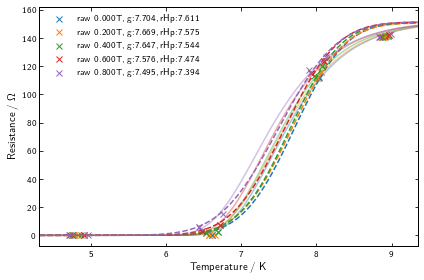

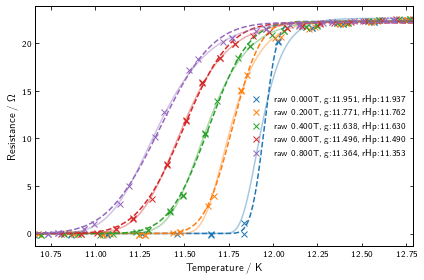

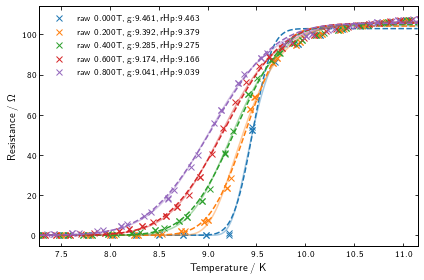

In [155]:
%matplotlib inline
filename_meas = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\Fitting_Auswertung\\'\
                'Paramter_playing\\All_RvsT_bin005\\'

for i,j in zip(quick_data_2, filename2):
    try:
        sample_postfix_2 = re.search(r'_diffusweep_\w*', j)[0]
        sample_postfix_2 = sample_postfix_2[12:]
    except:
        sample_postfix_2 = ''
    date_sample_j = re.search(r'\d{6}_\d{6}\w_', j)[0] + sample_postfix_2 + 'RvsT.pdf'
    pdfname = filename_meas + date_sample_j
    pdf = PdfPages(pdfname)
    b=B_sweep(i) # "r_b_sweeps" "r_t_sweeps"
    b.fit_area = 'full'
    b.fit_limit = 3
    b.fit_all_sweeps(b.B_values_dict)
    #print(b.B_values_dict_fit)
    b.get_Tc()
    fig=plt.figure()
    ax=fig.add_subplot(111)
    # # plots fits of T-R Sweeps depending on B
    i=0
    for key in b.B_values_dict_fit:
        if key in np.round(np.arange(0,1.0,0.2),2).tolist():#np.round(np.arange(0,0.8,0.1),2).tolist():#[0, 1.0, 2.0, 3.0, 4.0]:#[0,0.3,0.6,0.9,1.0]:#[1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]: np.round(np.arange(1.45,1.54,0.01),2).tolist()
            color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
            #ax.plot(b.B_values_dict[key][:,0], b.B_values_dict[key][:,1], 'x', label=r'raw '+ format_D_legend.format(key))
            ax.plot(b.B_values_dict[key][:,0], b.B_values_dict[key][:,1], 'x', label=r'raw '+ format_D_legend.format(abs(key))+r'T, g:'+format_D_legend.format(np.round(b.Tc[key]['gaussian'],3))+r', rHp:'+format_D_legend.format(np.round(b.Tc[key]['richardsHp'],3)), color=color)
            ax.plot(b.B_values_dict_fit[key]['gaussian'][1][0], b.B_values_dict_fit[key]['gaussian'][1][1], '--', color=color)
            ax.plot(b.B_values_dict_fit[key]['richards'][1][0], b.B_values_dict_fit[key]['richards'][1][1], '-', color=color, alpha=0.4)
            i+=1
    print(b.fit_fail)
    x_lim=b.B_values_dict_fit[key]['richards'][1][0]
    y_lim=b.B_values_dict_fit[key]['richards'][1][1] 
    #ax.plot(b.B_values_dict_fit[0.41][1][0], b.B_values_dict_fit[0.41][1][1], '-', label=f'fit {0.41}T')
    ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
    legend = ax.legend(handletextpad=0.1, loc='best', handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=1)
    plt.xlabel(r'Temperature / \si{\kelvin}')
    plt.ylabel(r'Resistance / \si{\ohm}')
    plt.xlim(x_lim[bisect_left(y_lim,1)]-0.1, x_lim[bisect_left(y_lim, 0.99*np.max(y_lim))]+0.6)
    #plt.xlim(7.5,11)
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight')
    pdf.close()

## import calib file

In [207]:
data_calib = np.loadtxt(calibfile_to_import, usecols=(0,1,2), skiprows=1)
#print(np.isnan(np.sum(data_calib))) 
data_calib = np.array([np.delete(data_calib[:,0], np.argwhere(np.isnan(data_calib[:,1]))), np.delete(data_calib[:,1], np.argwhere(np.isnan(data_calib[:,1]))), np.delete(data_calib[:,2], np.argwhere(np.isnan(data_calib[:,1])))]).transpose()
data_calib = np.array([np.delete(data_calib[:,0], np.argwhere(np.isnan(data_calib[:,2]))), np.delete(data_calib[:,1], np.argwhere(np.isnan(data_calib[:,2]))), np.delete(data_calib[:,2], np.argwhere(np.isnan(data_calib[:,2])))]).transpose()

# calibration_file = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Raw data\\Calibration\\calibration_diodes\\200210_191210A_calibration_data_n_moving_average_7.txt' #200210_191210A_film_vs_temp.txt
# data_calibration = np.loadtxt(calibfile_to_import, usecols=(0,1,2), skiprows=1)
# data_calibration = data_calibration[data_calibration[:,0]>500, :] # select values later than 500s (from then on curve is more or less smooth) and delete time column
# #print(data_calibration)
# # get rid of nans
# temp_data_calib = []
# for i in data_calibration:
#     if np.isnan(np.sum(i))==False:
#         temp_data_calib.append(i)
#     else: pass
# data_calibration = np.array(temp_data_calib)
# #print(data_calibration)

# load filtered and smoothed calibration data
#data_calibration = np.loadtxt(calibration_file, usecols=(0,1))


#print(type(data_calibration))
#print(np.isnan(np.sum(data_calibration)))
#print(len(data_calib[:,0]), len(data_calib[:,1]))
#print(data_calib)
#data = np.loadtxt(filename_to_import)
#calibfile_to_import = Path('//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Tc summary/Raw Data/Calibration_191206/Calibration_191030A_191211_fast_coupled.dat')
#data_calib=np.loadtxt(calibfile_to_import)
#print(data_calib[:,1].tolist())
#print(data)

### smooth and anaylse calibration data

In [ ]:
%matplotlib widget
#%matplotlib inline
#print(data_calibration)
a = apply_moving_average(15, data_calibration[:,1])
T_d = apply_moving_average(7, data_calibration[:,1])
T_s = apply_moving_average(7, data_calibration[:,2])
calib_data = np.array([T_d, T_s]).transpose()
#path_calib = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Raw data\\Calibration\\calibration_diodes\\200210_191210A_calibration_data_n_moving_average_7.txt'
#np.savetxt(path_calib, calib_data, delimiter='\t')

#print(a)
list1=[]
for i in np.arange(100,250):
    sum1=0
    for j in np.arange(-34, 35):
        sum1=sum1+data_calibration[i+j,1]
    value=sum1/len(np.arange(-34,35))
    list1.append([i,value])
list1=np.asarray(list1)
b=apply_moving_average(18, data_calibration[:,1])
c=apply_moving_average(75, data_calibration[:,1])
c_1 = apply_mov_av_convolve(75, data_calibration[:,1])
fig=plt.figure()
ax= fig.add_subplot(111)
#print(list1)
print(any(np.diff(a)<0))
print(any(np.diff(b)<0))
print(any(np.diff(c)<0))
ax.plot(data_calibration[:,1], '.-', label='raw')
# #ax.plot(a, '.-', label='over 5')
# #ax.plot(b, '.-', label='over 10')
# ax.plot(c, 'x-', label='over 75')
# ax.plot(c_1, '.-', label='over 75_old')
# ax.plot(list1[:,0], list1[:,1], '*-', label="manual")
plt.xlabel('index')
plt.ylabel('TEMP')
plt.legend()


#fig.canvas.layout.width = '10in'
#fig.canvas.layout.height= '6in'

## Error in linear temperature interpolation

In [208]:
# to fix: btw 8600 and 9900 there are no error calculations...
%matplotlib widget
#before = [np.concatenate(b.time_sweeps).ravel(), b.T_array]
#Check for linear error
# plot PDF
pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\Documents_Noah_OD\\BA\\Schreiben\\Thesis_BA_Noah_Ploch\\Thesis\\figures\\Appendix_Error\\temperature_error_interpolation_calibdata200210.pdf'
pdf = PdfPages(pdfname)

b=B_sweep(data, 'r_t_sweeps') # "r_b_sweeps" "r_t_sweeps"

data_calib = np.array([data_calib[:,0], data_calib[:,2]]).transpose()
window=550
#print(data_calib)
#print(np.mean(np.diff(data_calib[:,0])))
sample_rate=1/np.mean(np.diff(data_calib[:,0]))
j=0
indices_lost = []
linearization = []
max_error_list = np.array([])
max_error_pp = []
idx_start = ceil(300*sample_rate)
idx_end = len(data_calib[:,0])
print('Sample rate: ', sample_rate)
print('Start Index for 300s waiting time: ', idx_start)
for i in np.arange(idx_start,idx_start+len(data_calib[idx_start:idx_end,0])):
    try: 
        j=i+ceil(sample_rate*window)
        #print(j)
        #print(data_calib[i, :2])
        #print(data_calib[j, :2])
        fit = b.linear_interpolation(data_calib[i,:2], data_calib[j,:2], data_calib[i:j,0])
        error = fit-data_calib[i:j,1]
        error_p = abs(error)/data_calib[i:j,1]
        max_error = np.max(abs(error)) # max absolute error
        max_error_p = np.max(error_p)
        max_error_list = np.append(max_error_list, max_error)
        max_error_pp.append([data_calib[i,0], max_error_p])
        linearization.append([data_calib[i:j,1], fit, error, error_p, max_error, max_error_p])
    except:
        indices_lost.append(i)
max_error_pp = np.asarray(max_error_pp)
        
# b=B_sweep(data, 'r_t_sweeps') # "r_b_sweeps" "r_t_sweeps"
# #print(len(b.TBR_array[0]))
# #print(b.T_array)
# # temperature against time: linearized and timestamps

# time = np.array([])
# temperature = np.array([])
# for i,j in zip(b.time_sweeps, b.Temp_at_timestamp):
#             time = np.append(time, i[0])
#             temperature = np.append(temperature, j[0])

        

#print(indices_lost)
# fig=plt.figure()
# ax=fig.add_subplot(111)
# # plot singular error calculations -> search for max error fit
# ax.plot(np.arange(idx_start,idx_start+len(data_calib[idx_start:idx_end,0])-len(indices_lost)), max_error_pp, '.-', label='relative error')
# #ax.plot(linearization[34][0], '.-', label='data')
# #ax.plot(linearization[34][1], '.-', label='fit')
# #ax.plot(linearization[1][2], '.-', label='absolute error')
# #ax.plot(linearization[34][3], '.-', label='relative error')
# plt.xlabel('Index')
# plt.ylabel('Temperature')
# plt.title("Relative error (10.02.2020)")
# ax.legend()    
color = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
#gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 
#ax0 = plt.subplot(gs[0])
ax0.plot(data_calib[:,0], data_calib[:,1], color=color[0], linestyle='-')
#ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.plot(max_error_pp[:,0], max_error_pp[:,1], '-', color = color[0])
#plt.setp(ax0.get_xticklabels(), visible=False)
#yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel(r'Time / \si{\second}')
ax0.set_ylabel(r'Temperature / \si{\kelvin}')
ax1.set_ylabel(r'Relative error / \si{\percent}')
fig.subplots_adjust(hspace=0)
# plot raw data and max_errors
#ax.plot(data_calib[:,1], '.-', label='Temperature of bare-chip diode')
#ax.plot(data_calib[:,2], '.-', label='Temperature of sample diode')
#ax.plot(np.arange(idx_start,idx_start+len(data_calib[idx_start:idx_end,0])-len(indices_lost)),max_error_list, '.-', label='absolute error')



#ax.plot(b.B_sweeps[5], b.R_sweeps[5], '.-', label='data')

#plt.title("Self-Heating (10.02.2020)")
# legend = ax.legend(loc='best', handlelength=2.5)
# legend.get_frame().set_linewidth(0.0)   

# plot widget
# fig.canvas.layout.width = '7in'
# fig.canvas.layout.height= '6in'

#plot PDF
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()

<>:6: DeprecationWarning: invalid escape sequence \D
<>:6: DeprecationWarning: invalid escape sequence \D
<>:6: DeprecationWarning: invalid escape sequence \D
<ipython-input-208-c4fec56853a6>:6: DeprecationWarning: invalid escape sequence \D
  pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\Documents_Noah_OD\\BA\\Schreiben\\Thesis_BA_Noah_Ploch\\Thesis\\figures\\Appendix_Error\\temperature_error_interpolation_calibdata200210.pdf'


59.404942007060015
Len raw data:  20
Sample rate:  1.8440080223599848
Start Index for 300s waiting time:  554


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## B error determination

In this section we calculate the error that is assigned to the measurements of the magnetic field. When sweeping the magnet from 0T to 4.1T or 1.1T, we can take the lowest value (0T) and the highest value of these sweeps and compare them to the measured magnetic field (via the `output current monitor` of the Lakeshore625 and a Keithley2000 reading this voltage that is proportional to the current/magnetic field).

In [93]:
minB = 0.0
maxB = 4.1
delta_minB = 0.0
delta_maxB = 0.0

B_sweeps = B_sweep(data);
for this_sweep in B_sweeps.B_sweeps:
    sorted_sweep = np.sort(this_sweep)
    print(sorted_sweep[0],sorted_sweep[-1])
    delta_minB = max(delta_minB,abs(sorted_sweep[0]-minB))
    if abs((sorted_sweep[-1]-maxB)/maxB) < 0.1:
        delta_maxB = max(delta_maxB,abs(sorted_sweep[-1]-maxB))
print('delta_minB = %.3e, delta_maxB = %.3e'%(delta_minB,delta_maxB))
print('delta_minB/minB = %.3e, delta_maxB/maxB = %.3e'%(delta_minB/minB,delta_maxB/maxB))

168.0464411913175
-0.000154213225338 4.1125402056
-0.000105581519058 4.11264224838
-8.80422145032e-05 4.11223405914
-9.6413245716e-05 4.112336110979999
-0.000117540135594 4.112846343
-3.0242234881200003e-05 4.112846343
-0.00015301736422799998 4.11202996452
-6.332774047979999e-05 4.112744300219999
-7.8475321365e-05 4.11264224838
-9.3224281548e-05 4.1125402056
-8.24615268468e-05 4.112438153759999
-0.000124316684904 4.112846343
-8.32587679794e-05 4.11264224838
-7.1698772055e-05 4.112438153759999
-9.00353172894e-05 4.112744300219999
-0.000128302890114 4.1125402056
-9.282566147999999e-05 4.11264224838
-3.53463742386e-06 4.1119279217399995
delta_minB = 1.542e-04, delta_maxB = 1.285e-02
delta_minB/minB = inf, delta_maxB/maxB = 3.133e-03


/home/stefan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


When reading the magnetic field with the `output current monitor` of the Lakeshore625 we obtain for different `B_max` and `B_min` values (also shown at the front display in high precision) the following readings by the Matlab measurement script (accounting for errors of the output current monitor and the Keithley measuring the voltage)

|B_max |B_min | delta_minB | delta_maxB | delta_minB/minB | delta_maxB/maxB | evaluated file                     |
|------|------|------------|------------|-----------------|-----------------|------------------------------------|
|4.1T  |0.0T  | 1.287e-04  | 1.268e-02  | inf             | 3.093e-03       | 200309_200309A_diffusweep          |
|4.1T  |0.0T  | 1.430e-04  | 7.590e-02  | inf             | 1.851e-02       | 200228_200215A_diffusweep          |
|4.1T  |0.0T  | 1.805e-04  | 1.275e-02  | inf             | 3.110e-03       | 200219_200121A_diffusweep          |
|4.1T  |0.0T  | 1.578e-04  | 1.277e-02  | inf             | 3.114e-03       | 200217_200207A_diffusweep          |
|4.1T  |0.0T  | 1.542e-04  | 1.285e-02  | inf             | 3.133e-03       | 200211_191219A_diffusweep          |
|1.1T  |0.0T  | 1.801e-04  | 3.565e-03  | inf             | 3.241e-03       | 200305_200206A_diffusweep_1TSweep  |
|1.1T  |0.0T  | 1.698e-04  | 3.614e-03  | inf             | 3.285e-03       | 200217_191218A_diffusweep_1Tsweeps |

This means, we should be on the safe side by choosing the error of the magnetic field to be `2% of B + 1mT` (upper bound for the relavtive error + upper bound for the absolute error given for 0T for all the above analyzed measurements).

## Temperature Calibration - Calculations

In [ ]:
%matplotlib widget
b=B_sweep(data, 'r_t_sweeps', data_calibration) # "r_b_sweeps" "r_t_sweeps"
a = b.calibrated_Temp_at_timestamp
a= np.array([a])
print(a)
#print(b._raw_data[0])
error = abs(a[0][:,2]-a[0][:,0])
#print(error)
error_rel=error/a[0][:,2]
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(error_rel, '.-', label = 'relative error (T_sample-T-calculated)/T_sample')
plt.xlabel('Index of temperature stamp')
plt.ylabel('Relative error in %')
ax.legend()
#print(len(b.TBR_array[0]))
#print(b.T_array)
# temperature against time: linearized and timestamps





# time = np.array([])
# temperature_d = np.array([])
# temperature_s = np.array([])
# for i,j in zip(b.time_sweeps, b.Temp_at_timestamp):
#             time = np.append(time, i[0])
#             temperature_d = np.append(temperature_d, j[0])
#             temperature_s = np.append(temperature_s, j[2])

# #print(indices_lost)
# fig=plt.figure()
# ax=fig.add_subplot(111)
# # plot singular error calculations -> search for max error fit
# ax.plot(np.arange(idx_start,idx_start+len(data_calib[idx_start:idx_end,0])-len(indices_lost)), max_error_pp, '.-', label='relative error')
# #ax.plot(linearization[34][0], '.-', label='data')
# #ax.plot(linearization[34][1], '.-', label='fit')
# #ax.plot(linearization[1][2], '.-', label='absolute error')
# #ax.plot(linearization[34][3], '.-', label='relative error')
# plt.xlabel('Index')
# plt.ylabel('Temperature')
# plt.title("Relative error (10.02.2020)")
# ax.legend()    

# fig=plt.figure()
# ax=fig.add_subplot(111)
# # plot raw data and max_errors
# ax.plot(data_calib[:,0], data_calib[:,1], '.-', label='Temperature of bare-chip diode')
# ax.plot(data_calib[:,0], data_calib[:,2], '.-', label='Temperature of sample diode')
# #plt.plot(np.concatenate(b.time_sweeps).ravel(), np.concatenate(b.T_array).ravel(), '-', label='linear fit 191219A')
# #plt.plot(time, temperature_d, '.-', label="Temperature stamps diode")
# #plt.plot(time, temperature_s, '.-', label="Temperature stamps sample")
# #ax.plot(np.arange(idx_start,idx_start+len(data_calib[idx_start:idx_end,0])-len(indices_lost)),max_error_list, '.-', label='absolute error')
# #ax.plot(np.arange(idx_start,idx_start+len(data_calib[idx_start:idx_end,0])-len(indices_lost)), max_error_pp, '.-', label='relative error')
# plt.xlabel('Index')
# plt.ylabel('Temperature')
# plt.title("Self-Heating (10.02.2020)")
# ax.legend()   

# df = pd.DataFrame({'t[s]': time, 'TS_diode[K]': temperature_d, 'TS_sample[K]': temperature_s})
# path = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity_or_Electron_Diffusion_Constant\\Raw data\\Calibration\\Curves_Timestamps\\'
# name = '200110A_Temperature_stamps.csv'
# df.to_csv(path+name, sep="\t", header = ['t[s]', 'TS_diode[K]', 'TS_sample[K]'])
# print(df)

## Fit R against B sweeps

In [171]:
R_B_fitting=B_sweep(data, 'r_b_sweeps')
R_B_fitting.fit_all_sweeps(R_B_fitting.B_values_dict)
R_B_fitting.get_Bc2_from_B_sweeps()
R_B_fitting.get_Diffusivity()

fig=plt.figure()
ax=fig.add_subplot(111)

for i in R_B_fitting.B_sweeps_split:
    plt.plot(i[0][1][0], i[0][1][1], '-', label=f'cdf for Bc2={i[0][0]["mu"]}T')
    plt.plot(i[1][0], i[1][1], '.', label = f'raw data for {i[0][0]["mu"]}')
    print(f'{i[0][0]["mu"]}: scalar    mu     sigma')
    print(np.sqrt(np.diag(i[0][0]["cov"])))
plt.xlabel('Magnetic field (T)')
plt.ylabel('Resistance (Ω)')
#ax.legend()

59.404942007060015
Len raw data:  20


IndexError: index 1270 is out of bounds for axis 0 with size 1270

## Plotting of basic functionment

In [19]:
%matplotlib widget

test_fitting2 = B_sweep(data, 'r_t_sweeps')

# plot pdf
pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Documents_Noah_OD\\BA\\Schreiben\\Thesis_BA_Noah_Ploch\\Thesis\\figures\\Setup\\mg_sweep.pdf'
pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\use\\mg_sweep5.pdf'
#pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Documents_Noah_OD\\BA\\Schreiben\\Thesis_BA_Noah_Ploch\\Thesis\\figures\\Setup\\b_r_sweep.pdf'
# pdfname = 'H:\\Documents_H\\BA\\Schreiben\\Thesis_BA_Noah_Ploch\\Thesis\\figures\\Setup\\temperature_change.pdf'

pdf = PdfPages(pdfname)

# fig=plt.figure()
# ax1=fig.add_subplot(111)
# x1 =[3716.782 + 0, 3716.782 + 193.641, 3716.782 + 193.641*2]
# y1 = [0,4,0]
# ax1.plot(x1,y1, '-')
# ax1.set_xlabel(r'Time / $\si{\second}$')
# ax1.set_ylabel(r'Magnetic field strength / $\si{\tesla}$')


#plots B-R sweep
fig=plt.figure()
ax2=fig.add_subplot(111)
#idx1=9
idx1=13
ax2.plot(test_fitting2.B_sweeps[idx1], test_fitting2.R_sweeps[idx1], '-')
# ax2.plot(test_fitting2.time_sweeps[idx1], test_fitting2.B_sweeps[idx1], '-')
#ax2.plot(test_fitting2.B_sweeps[1], test_fitting2.R_sweeps[1], '.-')
#ax2.plot(test_fitting2.B_sweeps[5], test_fitting2.R_sweeps[5], 'x-')
#ax2.plot(test_fitting2.B_sweeps[6], test_fitting2.R_sweeps[6], '*-')
# ax2.set_xlabel(r'Magnetic field / $\si{\tesla}$')
ax2.set_ylabel(r'Resistance / $\si{\ohm}$')
# ax2.set_xlabel(r'Time / $\si{\second}$')
ax2.set_xlabel(r'Magnetic field / $\si{\tesla}$')
#ax2.set_xlim(3650,4150)


# fig=plt.figure()
# ax3=fig.add_subplot(111)
# print(test_fitting2.time_sweeps[idx1][0])
# y2=[test_fitting2.Temp_at_timestamp[idx1][2], test_fitting2.Temp_at_timestamp[idx1][3]]
# y3 = [test_fitting2.Temp_at_timestamp[idx1][0], test_fitting2.Temp_at_timestamp[idx1][1]]
# x2 = [test_fitting2.time_sweeps[idx1][0], test_fitting2.time_sweeps[idx1][-1]]
# ax3.plot(x2, y3, '-', label=r'PCB diode')
# ax3.plot(x2, y2, '-', label=r'Sample diode')
# ax3.set_xlabel(r'Time / $\si{\second}$')
# ax3.set_ylabel(r'Temperature / $\si{\tesla}$')
# legend = ax3.legend(loc='best', handlelength=2.5)
# legend.get_frame().set_linewidth(0.0)

ax2.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
legend = ax2.legend(loc='best', markerscale=3, handletextpad=0.1, handlelength=1.1, labelspacing=0.5, frameon=False, columnspacing=1)


# plot PDF
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()

59.63673057517659
Len raw data:  20


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

No handles with labels found to put in legend.


# Tc Data Analysis

### Search file

In [26]:
%gui qt5
default_path = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\'
filename_Tc = PureWindowsPath(default_path)
default_path = Path(filename_Tc)
filename_Tc = QFileDialog.getOpenFileName(None, 'Import file', str(default_path),"Text files (*.csv *.dat *.txt)")
print(filename_Tc[0])
file_to_import_Tc = Path(filename_Tc[0])
#filename_to_import = Path('testdata.dat')

//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/Data_measured/200306_A_Tc-Messung-100nm-NbTiN-SC-LT_R_vs_T_WMI.txt


### Search multiple files

In [46]:
%gui qt5
default_path = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated'
filename = PureWindowsPath(default_path)
default_path = Path(filename)
filename = QFileDialog.getOpenFileNames(None, 'Import file', str(default_path),"Text files (*.csv *.dat *.txt)")
filename = filename[0]
#print(filename)
quick_data = []
for i in filename:
    print(i)
    data_m = pd.read_csv(Path(i), sep=r'\t+\s*', engine='python')
    data_m.replace(['nan', 'None', 'NaN'], '', inplace=True)
    data_m = data_m.apply(pd.to_numeric)
    #data = [data[['raw_T']], data[['raw_R']]]
    data_m = data_m.to_numpy()
    #data = data.transpose()
    quick_data.append(data_m)
    
#print(quick_data)
    #print('Select from these columns: ', list(data)) # prints column names to be used in cell 'Plot'

//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/100nm_check/200306_200306A_100nmRvsT0T_100nm_20C_105ArN.txt
//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/100nm_check/200306_200306A_film_vs_temp_cooldown_100nmTcTest.txt
//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/100nm_check/200306_200306A_film_vs_temp_Tc_sweep_100nmTcTest.txt


### import Tc txt file from 0T sweep

In [168]:
# import Tc data
if 'Data_evaluated/Tc_sweeps' in filename_Tc[0]:
    full_data = pd.read_csv(file_to_import_Tc, sep='\t', usecols = ['raw_T', 'raw_R'])
    data_Tc = full_data.to_numpy()
    # get rid of nans
    temp_data_Tc = []
    for i in data_Tc:
        if np.isnan(np.sum(i))==False:
            temp_data_Tc.append(i)
            #print(i)
        else: pass
    #print(temp_data_Tc)
    data_Tc = np.array(temp_data_Tc)
else: data_Tc = np.loadtxt(file_to_import_Tc)
    
print(data_Tc.tolist())

[[4.047934267276137, 0.0], [4.046058160675951, -0.10080645161290322], [4.046055793894941, -0.10075566750629722], [4.046055793894941, 0.0], [4.048648947837012, 0.0], [4.04865244691855, 0.0], [4.04865244691855, 0.0], [4.0515975662303365, -0.1008318628686665], [4.0515975662303365, 0.0], [4.0859987995964895, 0.0], [4.086041382794956, 0.0], [4.086041382794956, -0.1008318628686665], [4.136519377574083, 0.0], [4.136582038683735, 0.0], [4.136582038683735, 0.0], [4.191358197458351, 0.0], [4.191435163846407, 0.0], [4.191435163846407, 0.0], [4.221847832757623, 0.0], [4.2218862552851135, 0.0], [4.2218862552851135, 0.0], [4.251266898800711, -0.10078105316200554], [4.251304348693981, -0.10080645161290322], [4.251304348693981, 0.0], [4.283908112657305, 0.0], [4.283949582088468, 0.0], [4.283949582088468, 0.0], [4.318519521649376, -0.10078105316200554], [4.318569636503407, -0.10075566750629722], [4.318569636503407, 0.0], [4.367443653251828, 0.0], [4.367509484568472, 0.0], [4.367509484568472, -0.1007810

#### Execute for Tc curves from diffusivity (0T)

In [457]:
%matplotlib widget
Tc_data = T_sweep(data_Tc) # eingeben nur T und R colummn
Tc_data.sweep_fit = [Tc_data.gauss_cdf_fit(data_Tc[:,0], data_Tc[:,1], np.arange(4,16,0.01))]
#print(Tc_data.sweep_fit)
Tc_data.get_Tc()
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(data_Tc[:,0], data_Tc[:,1], '.')
ax.plot(Tc_data._raw_fit[0][1][0], Tc_data._raw_fit[0][1][1], '-', label = r'$Tc = \SI{'+str(np.round(Tc_data.Tc[0], 3))+r'}{\kelvin}$')
#ax.text(0.5,0.2,r'$Tc = \SI{'+str(np.round(Tc_data.Tc[0], 3))+r'}{\kelvin}$', ha='right', va='top', transform=ax.transAxes)
#ax.plot(Tc_data._raw_fit[1][0], Tc_data._raw_fit[1][1], '-', label='Fitting (Gaussian CDF)')
#ax.legend()
legend = ax.legend(loc='lower right', handlelength=2.5)
legend.get_frame().set_linewidth(0.0)
#ax.set_title(r'R over T')
ax.set_xlabel(r'Temperature (K)')
ax.set_ylabel(r'Resistance (Ohm)')
# fig.canvas.layout.width = '7in'
# fig.canvas.layout.height= '6in'
print(Tc_data.Tc[0], Tc_data.Tc[1], Tc_data.Tc[2])

4.334677419354839
Len raw data:  37
Moving average to separate sweeps:  0
Moving average to smooth sweeps:  1


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

12.786787932834942 0.7574520540177261 0.8307140021815052


### import txt file from cooldown

In [20]:
# import Tc data
try:
    data_Tc = np.loadtxt(file_to_import_Tc, usecols=(2,5))
except:
    data_Tc = np.loadtxt(file_to_import_Tc, usecols=(2,5), skiprows=1)

#### import from WMI

In [124]:
data_Tc = pd.read_csv(file_to_import_Tc, sep=r'\t+\s*', engine='python')
data_Tc = data_Tc.to_numpy()
# get rid of nans
temp_data_Tc = []
for i in data_Tc:
    if np.isnan(np.sum(i))==False:
        temp_data_Tc.append(i)
        #print(i)
    else: pass
#print(temp_data_Tc)
data_Tc = np.array(temp_data_Tc)
data_Tc = data_Tc[:,[0,2]]
print(data_Tc)
#data_Tc = np.loadtxt(file_to_import_Tc, usecols=(0,1), skiprows=1)

[[ 4.002300e+00  7.874690e-04]
 [ 4.002300e+00 -1.230000e-03]
 [ 4.002200e+00  7.606620e-04]
 ...
 [ 1.699900e+01  2.355799e+01]
 [ 1.703800e+01  2.355944e+01]
 [ 1.698400e+01  2.356070e+01]]


### import txt file from Tc stick

In [32]:
# import Tc data
data_Tc = np.loadtxt(file_to_import_Tc)

### Execute for measured Tc_curves

In [12]:
Tc_data = T_sweep(data_Tc) # eingeben nur T unr R colummn
#calib_data = T_sweep(data_calib)

### Analysis

In [36]:
formatted_data = {'R20': Tc_data.R20K} #, 'Mean Tc': Tc_data.Tc[0], 'sigma Tc': Tc_data.Tc[1], 'Tc_values': Tc_data.Tc[2], 'Mean FWHM': Tc_data.FWHM[0], } 
#pd.DataFrame(data=formatted_data)
print("R20: ", Tc_data.R20K)

R20:  115.09191277032741


### Plot from B class a tc sweep

In [125]:
%matplotlib widget
c=B_sweep(data)
c.b_start_rich = 50
# data_Tc = data_Tc[data_Tc[:,0]>12,:]
# data_Tc = data_Tc[data_Tc[:,0]<13.5,:]
# data_Tc = data_Tc[::5,:]
# data_Tc = data_Tc[::5,:]
#print(data_Tc)

fit = c.fit_Tc_sweep(data_Tc)
Tc = c.get_Tc(fit)
print('gaussian: ', np.sqrt(np.diag(fit['gaussian'][0]['cov'])))
print('richards: ', np.sqrt(np.diag(fit['richards'][0]['cov'])))
#print(Tc)
#pdfname = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\richards_testing_Tc_112-114.pdf'
pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\use\\richards_fitting_situations.pdf'
pdf = PdfPages(pdfname)
fig = plt.figure()
ax=fig.add_subplot(111)
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
# gauss
# ax.plot(data_Tc[:,0], data_Tc[:,1], '1', ms=5, alpha=0.9, color=color, label=r'$T_\text{c}: \SI{'+format_T_legend.format(np.round(Tc['gaussian'],3))+r'}{\kelvin}$')
# ax.plot(fit['gaussian'][1][0], fit['gaussian'][1][1], '-', alpha=0.9, color=color)
# richards
ax.plot(data_Tc[:,0], data_Tc[:,1], '1', ms=5, alpha=0.9, color=color, label=r'$T_\text{c}: \SI{'+format_T_legend.format(np.round(Tc['richardsHp'],3))+r'}{\kelvin}$')
ax.plot(fit['richards'][1][0], fit['richards'][1][1], '-', alpha=0.9, color=color)

# temp_down = data_Tc[data_Tc[:,0]<12.65,:] 
# temp_up = data_Tc[data_Tc[:,0]>13.35,:] 
## temp_down = data_Tc[data_Tc[:,0]<11.2,:] # for first 8V measurememtn 200117
## temp_up = data_Tc[data_Tc[:,0]>11.9,:] 
# temp_middle = data_Tc[data_Tc[:,0]>12.4,:]
# temp_middle = temp_middle[temp_middle[:,0]<13.4,:]
# temp_middle = temp_middle[::6,:]

#data_Tc=np.concatenate((temp_down, temp_up))
data_Tc = data_Tc[::42,:]

c=B_sweep(data)
fit = c.fit_Tc_sweep(data_Tc)
Tc = c.get_Tc(fit)
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
# gauss
# ax.plot(data_Tc[:,0], data_Tc[:,1], '2', ms=7, alpha=0.9, color=color, label=r'$T_\text{c}: \SI{'+format_T_legend.format(np.round(Tc['gaussian'],3))+r'}{\kelvin}$')
# ax.plot(fit['gaussian'][1][0], fit['gaussian'][1][1], '-', alpha=0.9, color=color)
# richards
ax.plot(data_Tc[:,0], data_Tc[:,1], '2', ms=7, alpha=0.9, color=color, label=r'$T_\text{c}: \SI{'+format_T_legend.format(np.round(Tc['richardsHp'],3))+r'}{\kelvin}$')
ax.plot(fit['richards'][1][0], fit['richards'][1][1], '-', alpha=0.9, color=color)

#print(fit['richards'][0]['param'])
plt.xlabel(r'Temperature / \si{\kelvin}')
plt.ylabel(r'Resistance / \si{\ohm}')
#plt.xlim(11,11.6)
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
legend = ax.legend(markerscale=0.75,handletextpad=0.1, loc='best', handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=1)
#plt.xlim(12.4,13.6)
plt.xlim(11,15)
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()
#ax.plot(fit['richards'][1][0], fit['richards'][1][1], '-', alpha=0.4)

58.930373360242186
Len raw data:  60


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:304: RuntimeWarning: overflow encountered in float_power
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:304: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:304: RuntimeWarning: overflow encountered in true_divide


gaussian:  [0.00566966 0.00012968 0.00018823]
richards:  [7.60505667e-01 2.22638168e-01 2.49894139e-05 6.86675625e-03]


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

58.930373360242186
Len raw data:  60


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:304: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:304: RuntimeWarning: overflow encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:304: RuntimeWarning: overflow encountered in float_power


### Plot Methods Tc

In [52]:
%matplotlib widget
pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\use\\Tc_methods.pdf'
pdf = PdfPages(pdfname)
scale_1= 0.8
fig_width_pt_1 = 432.487                     # Get this from LaTeX using \showthe\textwidth
inches_per_pt_1 = 1.0/72.27                       # Convert pt to inch
#golden_mean_1 = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio
fig_width_1 = fig_width_pt_1*inches_per_pt_1*scale_1   # width in inches
fig_height_1 = fig_width_pt_1*inches_per_pt_1*scale_1             # height in inches
fig_size_1 = [fig_width_1,fig_height_1]

params1 = {
    'figure.figsize': fig_size_1, # default figsize
    }
mpl.rcParams.update(params1)
fig = plt.figure()
M=[r'zero-T', r'cooldown', r'T-sweep']
leg = ['lower right', 'best', 'best']
Lim = [(11, 15),(12.2, 14.2),(11.8, 13.5)]

#print(quick_data)
quick_data_Methods = []
quick_data_Methods.append(quick_data[0])
quick_data_Methods.append(quick_data[1][::-1,[2,5]])
quick_data_Methods.append(quick_data[2][:,[2,5]])
for i in range(len(quick_data_Methods)):
    c=B_sweep(data)
    data_Tc=quick_data_Methods[i]
    c.B_values_dict = {0.0: data_Tc}
    if i==0:
        c.b_start_rich =8
    if i==1:
        c.b_start_rich =10
    if i==2:
        c.b_start_rich =10
    c.B_values_dict_fit[0.0] = c.fit_cdf_over_range(data_Tc, np.max(data_Tc[:,1]))
    c.get_Bc2()
    fit= c.B_values_dict_fit[0.0]
    Tc = c.get_Tc(fit)

    ax=fig.add_subplot(2,2,i+1)
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    # gauss
    # ax.plot(data_Tc[:,0], data_Tc[:,1], '1', ms=5, alpha=0.9, color=color, label=r'$T_\text{c}: \SI{'+format_T_legend.format(np.round(Tc['gaussian'],3))+r'}{\kelvin}$')
    # ax.plot(fit['gaussian'][1][0], fit['gaussian'][1][1], '-', alpha=0.9, color=color)
    # richards
    ax.plot(data_Tc[:,0], data_Tc[:,1], '1', ms=5, alpha=0.9)
    ax.plot(fit['richards'][1][0], fit['richards'][1][1], '-', alpha=0.9, label=r'$T_\text{c}= \SI{'+format_T_legend.format(np.round(Tc['richardsHp'],3))+r'}{\kelvin}$')
    print(M[i])
    print([Tc['richardsHp'], c.Bc2[:,2], c.Bc2[:,3]])

    x_lim =fit['richards'][1][0]
    y_lim = fit['richards'][1][1]
    #print(fit['richards'][0]['param'])
    plt.xlabel(r'Temperature / \si{\kelvin}')
    plt.ylabel(r'Resistance / \si{\ohm}')
    plt.title(M[i])
    #plt.xlim(11,11.6)
    ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
    legend = ax.legend(markerscale=0.75,handletextpad=0.5, loc=leg[i], handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=1)
    ax.set_xlim(Lim[i])
    #plt.xlim(x_lim[bisect_left(y_lim,0.1)]-0.1, x_lim[bisect_left(y_lim, 0.99*np.max(y_lim))]+0.6)
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()
#ax.plot(fit['richards'][1][0], fit['richards'][1][1], '-', alpha=0.4)

C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:303: RuntimeWarning: overflow encountered in float_power


58.930373360242186
Len raw data:  60
zero-T
[12.447315705467938, array([0.41797983]), array([0.51930708])]
58.930373360242186
Len raw data:  60


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:221: RuntimeWarning: invalid value encountered in less
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:389: RuntimeWarning: invalid value encountered in less
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:390: RuntimeWarning: invalid value encountered in greater


cooldown
[12.800488760121466, array([0.38302501]), array([0.26891499])]
58.930373360242186
Len raw data:  60


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:303: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:303: RuntimeWarning: overflow encountered in true_divide


T-sweep
[12.299060273728504, array([0.18090777]), array([0.17479098])]


### plot Comparison_numericalchapter results

In [27]:
%matplotlib widget
c=B_sweep(data)

# data_Tc = data_Tc[data_Tc[:,0]>12,:]
# data_Tc = data_Tc[data_Tc[:,0]<13.5,:]
# data_Tc = data_Tc[::5,:]
# data_Tc = data_Tc[::5,:]
#print(data_Tc)

fit = c.fit_Tc_sweep(data_Tc)
Tc = c.get_Tc(fit)
print('gaussian: ', np.sqrt(np.diag(fit['gaussian'][0]['cov'])))
print('richards: ', np.sqrt(np.diag(fit['richards'][0]['cov'])))
#print(Tc)
#pdfname = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\richards_testing_Tc_112-114.pdf'
pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\use\\r_g_fitting_numerical.pdf'
pdf = PdfPages(pdfname)
fig = plt.figure()
ax=fig.add_subplot(111)
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
# gauss
ax.plot(data_Tc[:,0], data_Tc[:,1], '1', ms=5, alpha=0.9, color=color)
#ax.plot(fit['gaussian'][1][0], fit['gaussian'][1][1], '-', alpha=0.6, color=color, label=r'Gauss')
# richards
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
ax.plot(fit['richards'][1][0], fit['richards'][1][1], '-', alpha=0.6, color=color, label=r'Richards: b = '+ format_B_legend.format(abs(np.round(c.b_start_rich,3))))

c=B_sweep(data)
c.b_start_rich = 25
fit = c.fit_Tc_sweep(data_Tc)
Tc = c.get_Tc(fit)
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
ax.plot(fit['richards'][1][0], fit['richards'][1][1], '-', alpha=0.6, color=color, label=r'Richards: b = '+ format_B_legend.format(np.round(c.b_start_rich,3)))

c=B_sweep(data)
c.b_start_rich = 50
fit = c.fit_Tc_sweep(data_Tc)
Tc = c.get_Tc(fit)
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
ax.plot(fit['richards'][1][0], fit['richards'][1][1], '-', alpha=0.6, color=color , label=r'Richards: b = '+ format_B_legend.format(np.round(c.b_start_rich,3)))

#print(fit['richards'][0]['param'])
plt.xlabel(r'Temperature / \si{\kelvin}')
plt.ylabel(r'Resistance / \si{\ohm}')
#plt.xlim(11,11.6)
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
legend = ax.legend(markerscale=0.75,handletextpad=0.5, loc='lower right', handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=1)
plt.xlim(12.6,13.4)
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()
#ax.plot(fit['richards'][1][0], fit['richards'][1][1], '-', alpha=0.4)

107.49243188698286
Len raw data:  16


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:303: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:303: RuntimeWarning: overflow encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:303: RuntimeWarning: overflow encountered in float_power


gaussian:  [0.00566966 0.00012968 0.00018823]
richards:  [6.38803898e-01 3.54896589e-01 1.59119563e-06 4.12019486e-02]


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

107.49243188698286
Len raw data:  16


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:303: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:303: RuntimeWarning: overflow encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:303: RuntimeWarning: overflow encountered in float_power


107.49243188698286
Len raw data:  16


### Raw data

No handles with labels found to put in legend.


[{'param': array([43.51722211, -6.77839602,  0.98972475, 23.57622196, 33.03266616,
       34.27311233,  0.89160216]), 'cov': array([[inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf]])}, [array([ 4.  ,  4.01,  4.02, ..., 15.97, 15.98, 15.99]), array([23.3438804, 23.3438804, 23.3438804, ..., 23.3438804, 23.3438804,
       23.3438804])], [array([0.08515263, 0.08407175, 0.08362275, ..., 0.2051925 , 0.20524125,
       0.2052975 ]), array([-0.0017137,  0.       ,  0.       , ...,  0.4408678,  0.4403119,
        0.4402014]), 0.6353925, 0.26771499999999904]]


Text(0, 0.5, 'Resistance / \\si{\\ohm}')

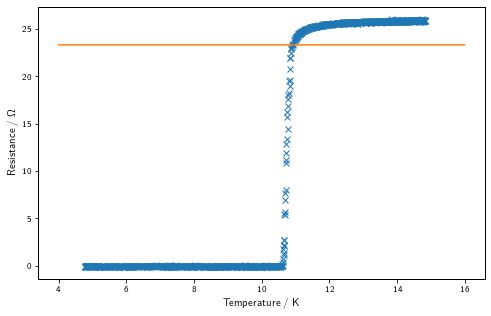

In [41]:
%matplotlib inline
# path_Tc = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated\\Tc_sweeps\\' 
# pdfname_Tc = path_Tc + '\\' + date_sample + 'Tc_sweepPlot_DT670currentWhenReadT' + sample_param + '.pdf'

# pdfname = pdfname_Tc
# pdf = PdfPages(pdfname)

fig = plt.figure(figsize=(8,5))
ax=fig.add_subplot(111)
ax.plot(Tc_data._raw_data.transpose()[0], Tc_data._raw_data.transpose()[1], 'x', label=r'g:'+format_D_legend.format(np.round(Tc_data.Tc[key]['gaussian'],3))+r', rTp:'+format_D_legend.format(np.round(Tc_data.Tc[key]['richards'],3))+r')
#print(Tc_data._raw_fit)
ax.plot(Tc_data._raw_fit[1][0], Tc_data._raw_fit[1][1], '-')#laTc_datael=r'$T_c = \SI{' + format_D_legend.format(np.round(Tc_data.Tc[0], 3)) + r'}{\kelvin}$'
ax.plot(Tc_data._raw_fit[:,0], Tc_data.B_values_dict[key][:,1], 'x', label=r'raw '+ format_D_legend.format(key)+r'T, g:'+format_D_legend.format(np.round(Tc_data.Tc[key]['gaussian'],3))+r', r:'+format_D_legend.format(np.round(b.Tc[key]['richards'],3)), color=color)
#ax.plot(fit[key][1][0], fit[key][1][1], '-', label=f'fit {key}T')
# print(key)
#print(b.B_values_dict_fit[key]['gaussian'][1][1])
ax.plot(Tc_data.B_values_dict_fit[key]['gaussian'][1][0], Tc_data.B_values_dict_fit[key]['gaussian'][1][1], '--', color=color)
ax.plot(Tc_data.B_values_dict_fit[key]['richards'][1][0], Tc_data.B_values_dict_fit[key]['richards'][1][1], '-', color=color, alpha=0.4)

#print(Tc_data.Tc[0], Tc_data.Tc[1], Tc_data.Tc[2])
legend = ax.legend(loc='lower right', handlelength=2.5)
legend.get_frame().set_linewidth(0.0)
#ax.set_title(r'R over Tc')
ax.set_xlabel(r'Temperature / \si{\kelvin}')
ax.set_ylabel(r'Resistance / \si{\ohm}')
#plt.show()

# save pdf
# plt.tight_layout()
# pdf.savefig(bbox_inches='tight')
# pdf.close()

#colorway = ['#f2815a', '#000000', '#c1d34e']

#fig = go.Figure(data=go.Scatter(x=Tc_data._raw_data.transpose()[0], y=Tc_data._raw_data.transpose()[1], mode="markers", name="Raw data"))
#fig.add_trace(go.Scatter(x=Tc_data._raw_fit[0][1][0], y=Tc_data._raw_fit[0][1][1], mode="lines",name="Fitting (Gaussian CDF)"))
#fig.add_trace(go.Scatter(x=Tc_data._raw_fit[1][1][0], y=Tc_data._raw_fit[1][1][1], mode="lines",name="Fitting (Linear)"))
#fig.update_xaxes(title_text="Temperature (K)", ticks="inside", linecolor= 'black', linewidth= 1, mirror=True)
#fig.update_yaxes(title_text="Resistance (Ω)", ticks="inside", linecolor= 'black', linewidth= 1, mirror=True)
#layout = go.Layout(
#    title_text="R over Tc",
#    title_font_size=20,
#    #paper_bgcolor='rgba(0,0,0,0)',
#    plot_bgcolor='rgba(0,0,0,0)',
#    legend_bordercolor='black',
#    legend_borderwidth=1,
#    colorway=colorway,
#    width=800,
#    height=500,
#)
    
#fig.update_layout(layout)

#fig.show()

### multiple

In [220]:
%matplotlib widget
path_0T = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated\\Tc_sweeps\\from_0T_sweeps' + '\\test_sweep_comparison_magnetic_field_influence'
path_0T = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\use'
pdfname = path_0T + '\\' + 'B_Sweep_meas_comparison' + '.pdf'
pdf = PdfPages(pdfname)

scale_1= 0.8
fig_width_pt_1 = 432.487                     # Get this from LaTeX using \showthe\textwidth
inches_per_pt_1 = 1.0/72.27                       # Convert pt to inch
#golden_mean_1 = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio
fig_width_1 = fig_width_pt_1*inches_per_pt_1*scale_1   # width in inches
fig_height_1 = fig_width_pt_1*inches_per_pt_1*scale_1             # height in inches
fig_size_1 = [fig_width_1,fig_height_1]

params1 = {
    'figure.figsize': fig_size_1, # default figsize
    }
mpl.rcParams.update(params1)

# EXECUTE thesis layout AGAIN!!!

quick_data_0T = quick_data[::4] 
quick_data_1T = quick_data[1::4] 
quick_data_2T = quick_data[2::4] 
quick_data_3T = quick_data[3::4] 
quick_data_tot = [quick_data_0T, quick_data_1T, quick_data_2T, quick_data_3T]
plots = [221,222,223,224]
leg = ['upper left', 'best', 'best', 'best']
tit = [r'$B=\SI{0}{\tesla}$', r'$B=\SI{1}{\tesla}$', r'$B=\SI{2}{\tesla}$', r'$B=\SI{3}{\tesla}$']
fig = plt.figure()
for u in range(len(quick_data_tot)):
    y1_legend = [r'1: $T_c=\SI{', r'2: $T_c=\SI{', r'3: $T_c=\SI{', r'4: $T_c=\SI{']
    fitting_function = 'richards'
    quick_data_B = quick_data_tot[u]
    #quick_data_B.append(np.concatenate(quick_data_B))
    ax=fig.add_subplot(plots[u])

    for i in range(len(quick_data_B)):
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
        c=B_sweep(data)
        data_Tc_repro = quick_data_B[i]
        fit = c.fit_Tc_sweep(data_Tc_repro)
        Tc = c.get_Tc(fit)
    #     index_5= bisect_left(data_Tc_repro, 5.0)
    #     index_11= bisect_left(data_Tc_repro, 11.0)
        ax.plot(data_Tc_repro[:, 0], data_Tc_repro[:, 1], '1', color=color, ms=5, label = r'$T_{B_\text{c2}}=\SI{'+ format_T_legend.format(np.round(Tc['richardsHp'],3))+r'}{\kelvin}$')

        xy = (data_Tc_repro[0,0]-fit['errorTR'][0,0], data_Tc_repro[0,1]-fit['errorTR'][0,1])
        width = 2*fit['errorTR'][0,0]
        height = 2*fit['errorTR'][0,1]
        ax.add_patch(pat.Rectangle(xy, width, height, alpha=0.1,  linewidth=0.0, facecolor=color)) #label = r'Error in ($T$,$R$)',
        for j, k in zip(data_Tc_repro[1:,:], fit['errorTR'][1:,:]):
            xy = (j[0]-k[0], j[1]-k[1])
            width = 2*k[0]
            height = 2*k[1]
            ax.add_patch(pat.Rectangle(xy, width, height, alpha=0.1, linewidth=0.0, facecolor=color))
        ax.plot(fit[fitting_function][1][0], fit[fitting_function][1][1], '-', color=color, linewidth = 0.9, alpha=0.9)
    # legend = ax.legend(loc='lower right', handlelength=2.5)
    # legend.get_frame().set_linewidth(0.0)
    #ax.set_title(r'R over Tc')
    ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
    legend = ax.legend(markerscale=0.75,handletextpad=0.1, loc=leg[u], handlelength=0.4, labelspacing=0.5, frameon=False, columnspacing=1)
    if plots[u] in [223,224]:
        ax.set_xlabel(r'Temperature / \si{\kelvin}')
    if plots[u] in [221,223]:
        ax.set_ylabel(r'Resistance / \si{\ohm}')
    ax.set_xlim(4.5,11)
    ax.set_title(tit[u])
#plt.show()

# save pdf
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()

C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\use\\B_Sweep_meas_comparison.pdf'>
  """
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

4.4366019662213265
Len raw data:  14


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:303: RuntimeWarning: overflow encountered in float_power


4.4366019662213265
Len raw data:  14
4.4366019662213265
Len raw data:  14
4.4366019662213265
Len raw data:  14
4.4366019662213265
Len raw data:  14


C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:303: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipykernel_launcher.py:303: RuntimeWarning: overflow encountered in true_divide


4.4366019662213265
Len raw data:  14
4.4366019662213265
Len raw data:  14
4.4366019662213265
Len raw data:  14
4.4366019662213265
Len raw data:  14
4.4366019662213265
Len raw data:  14
4.4366019662213265
Len raw data:  14
4.4366019662213265
Len raw data:  14
4.4366019662213265
Len raw data:  14
4.4366019662213265
Len raw data:  14
4.4366019662213265
Len raw data:  14
4.4366019662213265
Len raw data:  14


In [86]:
%matplotlib widget
path_0T = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated\\Tc_sweeps\\from_0T_sweeps' + '\\test_sweep_comparison_magnetic_field_influence'
#path_0T = 'K:\\BANP\\Diffusivity\\Data_evaluated\\Tc_sweeps\\from_0T_sweeps' + '\\test_sweep_comparison_magnetic_field_influence'
pdfname = path_0T + '\\' + 'Sweep_comparison_3T_fit_little' + '.pdf'
pdf = PdfPages(pdfname)


y1_legend = [r'1: $T_c=\SI{', r'2: $T_c=\SI{', r'3: $T_c=\SI{', r'4: $T_c=\SI{']
fig = plt.figure()
ax=fig.add_subplot(111)

for i in range(len(quick_data)):
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
    Tc_data = T_sweep(quick_data[i])
    index_5= bisect_left(Tc_data._raw_data.transpose()[0], 5.0)
    index_11= bisect_left(Tc_data._raw_data.transpose()[0], 11.0)
    ax.plot(Tc_data._raw_data[index_5:index_11, 0], Tc_data._raw_data[index_5:index_11, 1], 'x', color=color, ms=3)
    xy = (Tc_data._raw_data[index_5,0]-Tc_data._raw_fit[2][0][index_5], Tc_data._raw_data[index_5,1]-Tc_data._raw_fit[2][1][index_5])
    width = 2*Tc_data._raw_fit[2][0][0]
    height = 2*Tc_data._raw_fit[2][1][0]
    ax.add_patch(pat.Rectangle(xy, width, height, alpha=0.3, label = r'Error in ($T$,$R$)', linewidth=0.0, facecolor=color))
    for j, k, l in zip(Tc_data._raw_data[index_5+1:index_11], Tc_data._raw_fit[2][0][index_5+1:index_11], Tc_data._raw_fit[2][1][index_5+1:index_11]):
        xy = (j[0]-k, j[1]-l)
        width = 2*k
        height = 2*l
        ax.add_patch(pat.Rectangle(xy, width, height, alpha=0.3, linewidth=0.0, facecolor=color))
#     print(Tc_data.Tc[0])
#     ax.fill_between(Tc_data._raw_data[:,0], Tc_data._raw_data[:,1]-Tc_data._raw_fit[2][1],
#             Tc_data._raw_data[:,1]+Tc_data._raw_fit[2][1],
#             alpha=0.6, facecolor=color,
#             linewidth=0.0, label=r'Error in $R$')
#     lower_error_T = Tc_data._raw_data[:,0]-Tc_data._raw_fit[2][0]
#     upper_error_T =Tc_data._raw_data[:,0]+Tc_data._raw_fit[2][0]
#     ax.fill(np.append(lower_error_T, upper_error_T[::-1]), np.append(Tc_data._raw_data[:,1], Tc_data._raw_data[::-1,1]),
#                 alpha=0.2, facecolor=color,
#                 linewidth=0.0, label=r'Error in $T$')
    #ax.plot(Tc_data._raw_data[:,0], Tc_data._raw_data[:,1], '-', color=color, label=r'$B = \SI{'+format_B_legend.format(key)+r'}{\tesla}$', linewidth = 0.7)
#     slice_fit_T = Tc_data._raw_fit[1][0][(Tc_data._raw_fit[1][0] <= Tc_data._raw_data[index_11,0]) & (Tc_data._raw_fit[1][0] >= Tc_data._raw_data[index_5,0])]
#     slice_fit_R = Tc_data._raw_fit[1][1][(Tc_data._raw_fit[1][0] <= Tc_data._raw_data[index_11,0]) & (Tc_data._raw_fit[1][0] >= Tc_data._raw_data[index_5,0])]
    slice_fit_T = Tc_data._raw_fit[1][0][(Tc_data._raw_fit[1][0] <= 11) & (Tc_data._raw_fit[1][0] >= 5)]
    slice_fit_R = Tc_data._raw_fit[1][1][(Tc_data._raw_fit[1][0] <= 11) & (Tc_data._raw_fit[1][0] >= 5)]
    ax.plot(slice_fit_T, slice_fit_R, '-', label=y1_legend[i] + format_D_legend.format(np.round(Tc_data.Tc[0], 3)) + r'}{\kelvin}$', color=color, linewidth=0.8)
# legend = ax.legend(loc='lower right', handlelength=2.5)
# legend.get_frame().set_linewidth(0.0)
#ax.set_title(r'R over Tc')
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
legend = ax.legend(markerscale=0.75,handletextpad=0.5, loc='lower right', handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=1)
ax.set_xlabel(r'Temperature / \si{\kelvin}')
ax.set_ylabel(r'Resistance / \si{\ohm}')
#plt.xlim(5,11)
#plt.show()

# save pdf
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()

K:\Programs\anaconda3\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
K:\Programs\anaconda3\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

152.13114754098362
Len raw data:  81
Moving average to separate sweeps:  1
Moving average to smooth sweeps:  1
154.6626231993935
Len raw data:  71
Moving average to separate sweeps:  1
Moving average to smooth sweeps:  1
154.6006066734075
Len raw data:  97
Moving average to separate sweeps:  2
Moving average to smooth sweeps:  1
139.75044563279855
Len raw data:  129
Moving average to separate sweeps:  3
Moving average to smooth sweeps:  1


### 1T 4T Sweep comparison

In [62]:
%gui qt5
default_path = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated'
filename = PureWindowsPath(default_path)
default_path = Path(filename)
filename = QFileDialog.getOpenFileNames(None, 'Import file', str(default_path),"Text files (*.csv *.dat *.txt)")
filename = filename[0]
#print(filename)
quick_data = []
for i in filename:
    print(i)
    data_q = pd.read_csv(Path(i), sep=r'\t+\s*', engine='python')
    data_q.replace(['nan', 'None', 'NaN'], '', inplace=True)
    data_q = data_q.apply(pd.to_numeric)
    #data = [data[['raw_T']], data[['raw_R']]]
    data_q = data_q.to_numpy()
    #data = data.transpose()
    quick_data.append(data_q)

//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/Data_evaluated/Bc2_vs_T/200303_200116A_Bc2vsT_10nm_400C_105ArN.txt


In [63]:
%matplotlib widget
decimal.getcontext().rounding = decimal.ROUND_CEILING

float(round(decimal.Decimal(str(0.1111)), ndigits=2))

fig=plt.figure()
ax=fig.add_subplot(111)

# plot PDF
#pdfname = 'H:\\Documents_H\\BA\\Schreiben\\Thesis_BA_Noah_Ploch\\Thesis\\figures\\Setup\\resistance_clean.pdf'
#path_0T = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated\\Tc_sweeps\\from_0T_sweeps' + '\\test_sweep_comparison_magnetic_field_influence'
path_0T = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated'
path_0T = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\use'
pdfname = path_0T + '\\' + 'comparison_4T_1T_red' + '.pdf'
pdf = PdfPages(pdfname)

x_header = 'raw_T' #'t[s]'
y1_header = 'raw_B' #'TS_diode[K]'#'T_diode [K]' # U_diode [V]
#y2_header = 'TS_sample[K]'#'T_sample [K]' # U_sample [V] 

#y1_legend = [r'1 (First meas)', r'2 (after weekend)', r'3 (directly after 2)', r'4 (after 3 with removal)']
y1_legend = [r'4T Sweep', r'1T Sweep']
y2_legend = '' #'sample temperature'
title = 'Longterm sample temperature stability'
x_label = r'Temperature / \si{\kelvin}'
y_label =  r'$B_{c2}$ / \si{\tesla}'
marker = 's'

quick_data = quick_data[::-1]
test_fitting = B_sweep(data, 'r_t_sweeps')
j=0

for i in range(len(quick_data)):
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
    test_fitting.Bc2 = quick_data[i]
    test_fitting.get_Diffusivity()
    plt.plot(test_fitting.Bc2[:,0], test_fitting.Bc2[:,1], marker,ms=4, mew=0, label=y1_legend[i], color=color)

for i in range(len(quick_data)):
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i+2]
    test_fitting.Bc2 = quick_data[i]
    if i==0:
        test_fitting.Bc2 = quick_data[i][100:-1,:]
    test_fitting.get_Diffusivity()
    #plt.plot(test_fitting.Bc2[:,0], test_fitting.Bc2[:,1], marker, label=y1_legend[j])
    #plt.plot(i[[x_header]].to_numpy(), i[[y1_header]].to_numpy(), marker)
    ax.plot(test_fitting.Bc2_fit[1][0], test_fitting.Bc2_fit[1][1], color=color, ls='-', label=r'$D = \SI[multi-part-units=single]{'+ format_D_legend.format(np.round(test_fitting.D[0], 3)) + r'\pm' + format_D_legend.format(float(round(decimal.Decimal(str(test_fitting.D[1])), ndigits=3))) + r'}{cm^2/s}$') #np.round(test_fitting.D[1], 3)
    #plt.plot(i[[x_header]].to_numpy(), i[[y2_header]].to_numpy(), marker, label=y2_legend + f' heating at {voltage}V')
    print(test_fitting.D)
    j+=1
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
legend = ax.legend(markerscale=1,handletextpad=1, loc='best', handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=1)
#plt.title(title)
plt.xlabel(x_label)
plt.ylabel(y_label)
#plt.xlim(5, 9)

# plot widget
# fig.canvas.layout.width = '7in'
# fig.canvas.layout.height= '6in'

#plot PDF
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()

C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
C:\Users\Noah.Ploch\Program\Anaconda\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

58.930373360242186
Len raw data:  60
[0.7135165618792735, 0.0003415168089167624]


### Sweeps

In [ ]:
%matplotlib widget

fig,ax = plt.subplots(nrows=1, ncols=len(Tc_data._sweep_raw))

for i in range(len(Tc_data._sweep_raw)):
    ax[i].plot(Tc_data._sweep_raw[i][0], Tc_data._sweep_raw[i][1], 'o', label='Raw data')
    ax[i].plot(Tc_data.sweep_fit[i][1][0], Tc_data.sweep_fit[i][1][1], '-', label='Fitting (Gaussian CDF)')
    ax[i].legend()
    ax[i].set_title(f'Temperature Sweep {i+1}')
    ax[i].set_xlabel('Temperature (K)')
    ax[i].set_ylabel('Resistance (Ω)')

plt.show()


# Du kannst auch die Ableitung der funktion bilden und da durch dann den Gauß peak legen (das kann man auch sehr schön plotten)

## Calibration 

In [ ]:
calibrate = Tc_data.map_calibration(Tc_data._sweep_raw[0], calib_data._sweep_raw[0])
colorway = ['#f2815a', '#000000', '#01215a']

print(calib_data._sweep_raw[1])
#print(calibrate[0][:,0])
#print(calibrate[1].tolist())
error = calibrate[1][:,1] - calibrate[1][:,0]
fig = go.Figure()
#fig.add_trace(go.Scatter(x=calibrate[1][:,0], y=error, mode="markers", name="cali_T"))
#fig.add_trace(go.Scatter(x=calibrate[0][:,0], y=calibrate[0][:,1], mode="markers",name="calibrated"))
fig.add_trace(go.Scatter(x=calibrate[2][:,0], y=calibrate[2][:,1], mode="markers",name="Tc Measurement coupled"))
fig.add_trace(go.Scatter(x=calibrate[3][:,0], y=calibrate[3][:,1], mode="markers",name="Tc Measurement free"))
fig.update_xaxes(title_text="Temperature", ticks="inside", linecolor= 'black', linewidth= 1, mirror=True)
#fig.update_yaxes(title_text="Error (Calib_T-Raw_T)", ticks="inside", linecolor= 'black', linewidth= 1, mirror=True)
fig.update_yaxes(title_text="Resistance (Ω)", ticks="inside", linecolor= 'black', linewidth= 1, mirror=True)
layout = go.Layout(

    title_text="R over Tc",
    title_font_size=20,
    #paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    legend_bordercolor='black',
    legend_borderwidth=1,
    colorway=colorway,
    width=800,
    height=500,
)
    
fig.update_layout(layout)

#fig.show()